## Configuración inicial

A continuación se importan las librerías necesarias para el funcionamiento del notebook.

In [2]:
#plots and data
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

#metrics and transformations
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

#Model 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM
from tensorflow import random 
from tensorflow.keras import callbacks

sns.set()

---

## Cargar y preparar los datos.

In [6]:
df = pd.read_csv("../../Datasets/Datos_antes_pandemia/data_antes_vol_in.csv")

df['Fecha'] = pd.to_datetime(df['Fecha'])
df = df.sort_values('Fecha', ascending=True)
df.rename(columns = {'Futuros': 'Vol. Futuros',},inplace=True)

df.reset_index(inplace=True,drop=True)
df

Fecha  Vol. Futuros        VIX  EMV-ID     EPU
0    2010-01-01      0.000000  22.543626    2.01  174.55
1    2010-01-02      4.256365  22.171185    0.00  119.52
2    2010-01-03      0.794545  21.143152    1.15  216.95
3    2010-01-04      0.787899  20.040000    1.22  150.35
4    2010-01-05      0.601027  19.350000    0.95  151.16
...         ...           ...        ...     ...     ...
3648 2019-12-27      4.003614  13.430000    0.00  127.92
3649 2019-12-28      2.090121  14.351756    0.00  123.10
3650 2019-12-29      0.539108  14.946538    4.26  245.14
3651 2019-12-30      1.815513  14.820000    0.97  101.31
3652 2019-12-31      1.871355  13.780000    1.54  105.75

[3653 rows x 5 columns]

---

## Desarrollo del modelo LSTM

In [12]:
#objects to scale the data 
sc=StandardScaler()
sc2=StandardScaler()

In [13]:
df_stats=df

In [14]:
#
len_data=df_stats.shape[0]

#get target
df_label=df_stats["Vol. Futuros"].values.reshape(len_data,1)
#get attributes
df_data=df_stats.drop(columns=["Fecha"])

#apply scale
df_label_normalize=sc.fit_transform(df_label)
df_data_normalize=sc2.fit_transform(df_data)


### Partición de los datos

In [15]:
#last index of the train data
eight_percent=int(len_data*0.7)

#split the data normalize
df_train=df_data_normalize[:eight_percent]
df_test=df_data_normalize[eight_percent:]

#split labels normalize
df_train_y_normalize=df_label_normalize[:eight_percent]
df_test_y_normalize=df_label_normalize[eight_percent:]

#split the original labels
df_train_y=df_label[:eight_percent]
df_test_y=df_label[eight_percent:]

In [16]:
def plot_metrics(history):
        # plot MAE and loss
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['mae'], label='mae')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['loss'], label='loss')
    plt.ylabel("value")
    plt.xlabel("epoch")
    plt.title("error a través de los epochs")
    plt.legend()
    plt.show()

In [17]:
def plot_predict_test(df_test_y,testPredict,lag):
        ### Resultado predicción datos de entrenamiento
    fig, ax = plt.subplots(figsize=[15,8])
    sns.lineplot(df_test_y[lag:].flatten(),label="real")
    sns.lineplot(testPredict.flatten(),label="predicción")
    plt.title("Comparación valor real y predicción")
    plt.ylabel("value")

In [18]:
#function to measure the performance
def timeseries_evaluation_metrics_func(y_true, y_pred,flag):
    def mean_absolute_percentage_error(y_true, y_pred): 
        epsilon=0.1e-5
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    if flag : print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    else:
        print('Evaluation metric results:')
        print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
        print(f'MAE is : {metrics.mean_absolute_error(y_true, y_pred)}')
        print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
        print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
        
    return {"MSE":metrics.mean_squared_error(y_true, y_pred),
           "MAE":metrics.mean_absolute_error(y_true, y_pred),
           "RMSE":np.sqrt(metrics.mean_squared_error(y_true, y_pred)),
           "MAPE":mean_absolute_percentage_error(y_true, y_pred)}

In [21]:
def Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons,attributes,epochss,batch_sizze,lag):
    #reshape train data
    
    len_df_train=df_train.shape[0]
    X_train=[]
    Y_train=[]
    for i in range(lag,len_df_train):
        X_train.append(df_train[i-lag:i])
        Y_train.append(df_train_y_normalize[i])

    X_train,Y_train=np.array(X_train),np.array(Y_train)
    print(X_train.shape,Y_train.shape)
    
    #reshape test data
    len_df_test=df_test.shape[0]
    X_test=[]
    Y_test=[]
    for i in range(lag,len_df_test):
        X_test.append(df_test[i-lag:i])
        Y_test.append(df_test_y_normalize[i])

    X_test,Y_test=np.array(X_test),np.array(Y_test)
    print(X_test.shape,Y_test.shape)
    
    
    #set the seed
    random.set_seed(7)

    #optional----
    #callback to early stopping and prevent overfitting
    #callback =callbacks.EarlyStopping(monitor='mae', patience=3)

    #make the model
    model=Sequential()
    model.add(LSTM(units=neurons,return_sequences=False,input_shape=(lag,attributes)))
    model.add(Dense(1))
    model.compile(optimizer='adamax',loss='mean_squared_error',metrics=['mae'])
    
    #fit the model with the train data
    history=model.fit(X_train,Y_train,validation_split=0.2,epochs=epochss,batch_size=batch_sizze)
    
    #plot metrics
    plot_metrics(history)
    
    # make predictions
    trainPredict = model.predict(X_train)

    # invert transformation
    trainPredict = sc.inverse_transform(trainPredict)
    trainY = df_train_y
    
    # make predictions
    model.reset_states()
    testPredict = model.predict(X_test)


    # invert transformation
    testPredict = sc.inverse_transform(testPredict)
    testY = df_test_y
    
    plot_predict_test(df_train_y,trainPredict,lag)
    plot_predict_test(df_test_y,testPredict,lag)
    
    return {"train":timeseries_evaluation_metrics_func(trainY.flatten()[lag:]+1, trainPredict.flatten()+1,False),
           "test":timeseries_evaluation_metrics_func(testY.flatten()[lag:]+1, testPredict.flatten()+1,False)}

## Resultados

(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 10ms/step - loss: 1.1816 - mae: 0.7731 - val_loss: 0.7842 - val_mae: 0.6884
Epoch 2/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1499 - mae: 0.7664 - val_loss: 0.7893 - val_mae: 0.6964
Epoch 3/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1367 - mae: 0.7680 - val_loss: 0.7912 - val_mae: 0.6980
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1287 - mae: 0.7660 - val_loss: 0.7913 - val_mae: 0.6975
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1238 - mae: 0.7633 - val_loss: 0.7935 - val_mae: 0.6990
Epoch 6/100
128/128 [==============================] - 1s 5ms/step - loss: 1.1200 - mae: 0.7651 - val_loss: 0.7932 - val_mae: 0.6985
Epoch 7/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1168 - mae: 0.7638 - val_loss: 0.7923 - val_mae: 0.6973
Epoch 8/100
128/128 [=

Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0753 - mae: 0.7516 - val_loss: 0.7905 - val_mae: 0.7027
Epoch 63/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0744 - mae: 0.7534 - val_loss: 0.7893 - val_mae: 0.7016
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0746 - mae: 0.7531 - val_loss: 0.7857 - val_mae: 0.6982
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0735 - mae: 0.7506 - val_loss: 0.7891 - val_mae: 0.7015
Epoch 66/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0733 - mae: 0.7520 - val_loss: 0.7892 - val_mae: 0.7018
Epoch 67/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0728 - mae: 0.7536 - val_loss: 0.7896 - val_mae: 0.7017
Epoch 68/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0720 - mae: 0.7512 - val_loss: 0.7910 - val_mae: 0.7029
Epoch 69/100
128/128 [==============================] - 1s 6ms

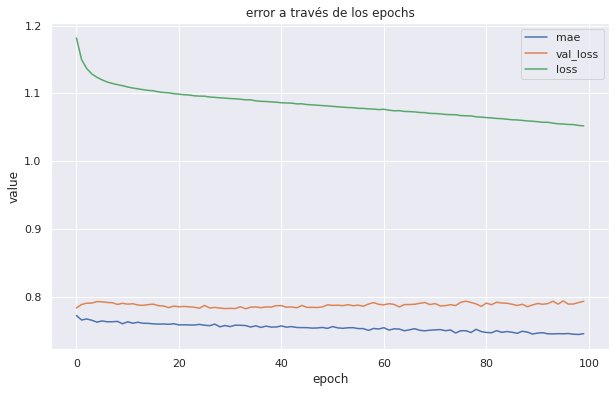

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.294911446690981
MAE is : 0.8393158209992981
RMSE is : 1.1379417589186984
MAPE is : 42.00071579224326
Evaluation metric results:
MSE is : 1.0145427529318158
MAE is : 0.7891876927836607
RMSE is : 1.0072451305078698
MAPE is : 44.22014885701569
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1371 - mae: 0.7660 - val_loss: 0.7971 - val_mae: 0.7049
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1211 - mae: 0.7636 - val_loss: 0.7962 - val_mae: 0.7046
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1155 - mae: 0.7662 - val_loss: 0.7933 - val_mae: 0.7017
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1124 - mae: 0.7636 - val_loss: 0.7898 - val_mae: 0.6987
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1102 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0530 - mae: 0.7478 - val_loss: 0.7889 - val_mae: 0.7058
Epoch 60/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0514 - mae: 0.7449 - val_loss: 0.7874 - val_mae: 0.7052
Epoch 61/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0515 - mae: 0.7473 - val_loss: 0.7836 - val_mae: 0.7016
Epoch 62/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0499 - mae: 0.7431 - val_loss: 0.7895 - val_mae: 0.7067
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0482 - mae: 0.7452 - val_loss: 0.7850 - val_mae: 0.7026
Epoch 64/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0484 - mae: 0.7445 - val_loss: 0.7780 - val_mae: 0.6965
Epoch 65/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0465 - mae: 0.7417 - val_loss: 0.7881 - val_mae: 0.7061
Epoch 66/100
128/128 [==============================] - 1s 6ms

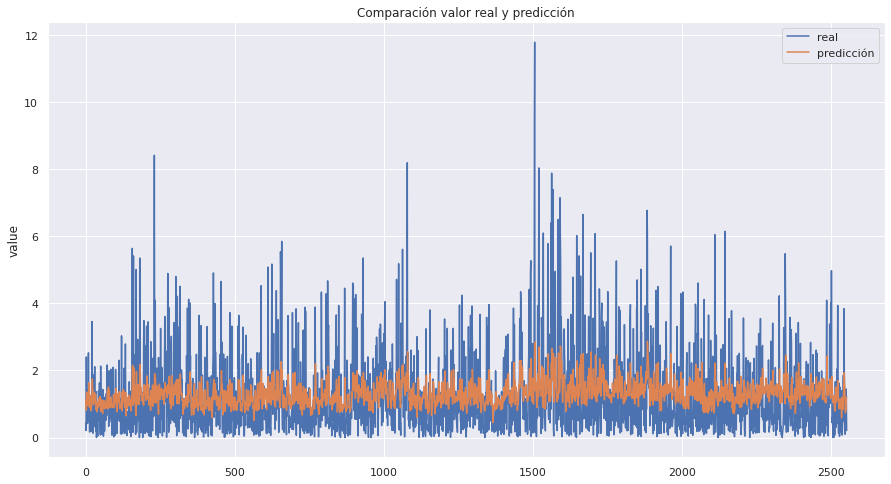

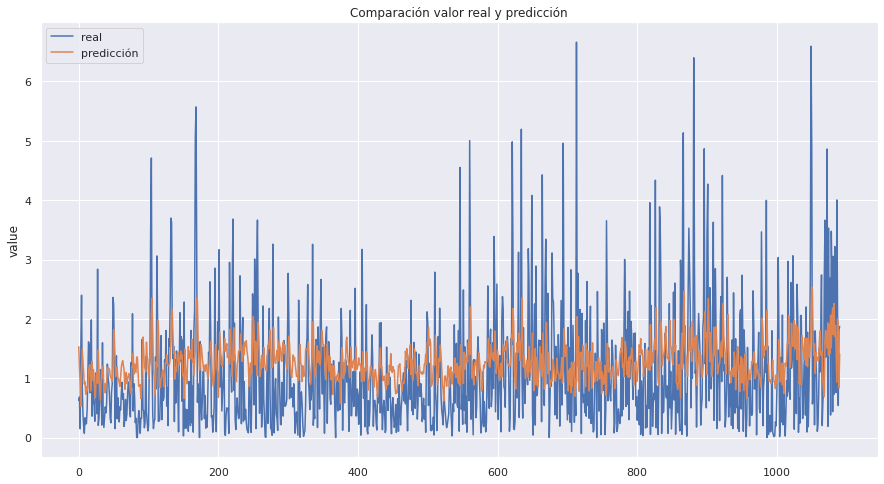

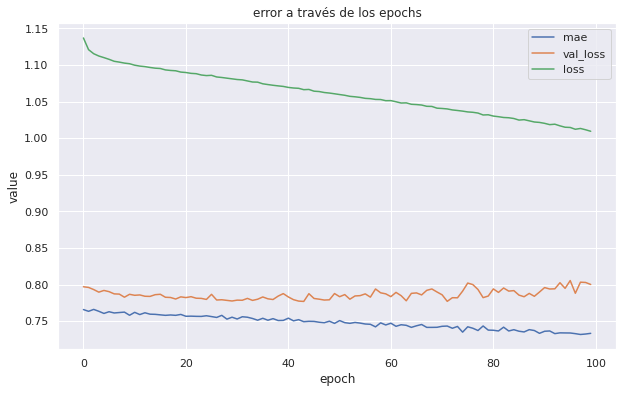

35/35 [==============================] - 0s 2ms/step
Evaluation metric results:
MSE is : 1.249318826767521
MAE is : 0.8271945057071898
RMSE is : 1.117729317306977
MAPE is : 41.31437832067271
Evaluation metric results:
MSE is : 1.0223835168490405
MAE is : 0.7846849732202954
RMSE is : 1.0111298219561327
MAPE is : 43.49990425333762
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 1.1594 - mae: 0.7733 - val_loss: 0.8055 - val_mae: 0.7036
Epoch 2/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1282 - mae: 0.7680 - val_loss: 0.8010 - val_mae: 0.7016
Epoch 3/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1196 - mae: 0.7697 - val_loss: 0.7967 - val_mae: 0.6987
Epoch 4/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1142 - mae: 0.7656 - val_loss: 0.7910 - val_mae: 0.6952
Epoch 5/100
128/128 [==============================] - 1s 6ms/step - loss: 1.1108 - mae: 0

Epoch 76/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0053 - mae: 0.7318 - val_loss: 0.8707 - val_mae: 0.7470
Epoch 77/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0032 - mae: 0.7284 - val_loss: 0.8660 - val_mae: 0.7429
Epoch 78/100
128/128 [==============================] - 1s 6ms/step - loss: 1.0005 - mae: 0.7228 - val_loss: 0.8529 - val_mae: 0.7323
Epoch 79/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9971 - mae: 0.7305 - val_loss: 0.8397 - val_mae: 0.7200
Epoch 80/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9967 - mae: 0.7243 - val_loss: 0.8500 - val_mae: 0.7258
Epoch 81/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9940 - mae: 0.7239 - val_loss: 0.8689 - val_mae: 0.7414
Epoch 82/100
128/128 [==============================] - 1s 6ms/step - loss: 0.9917 - mae: 0.7224 - val_loss: 0.8569 - val_mae: 0.7332
Epoch 83/100
128/128 [==============================] - 1s 7ms

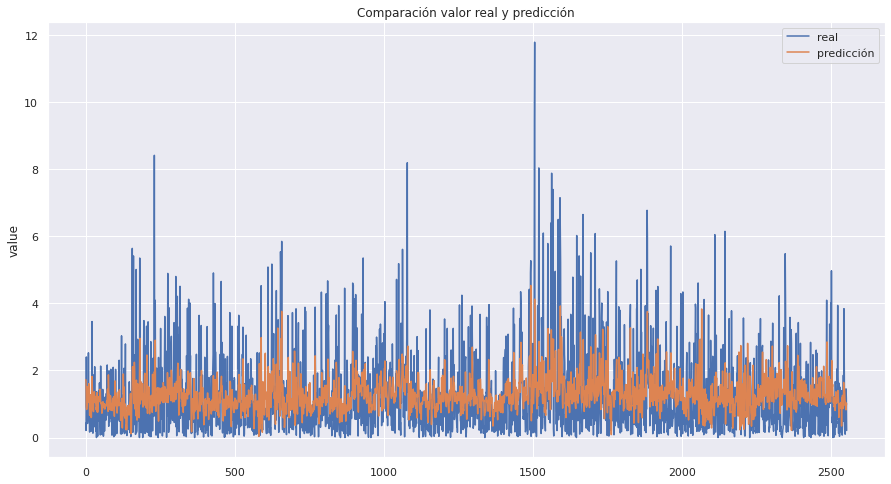

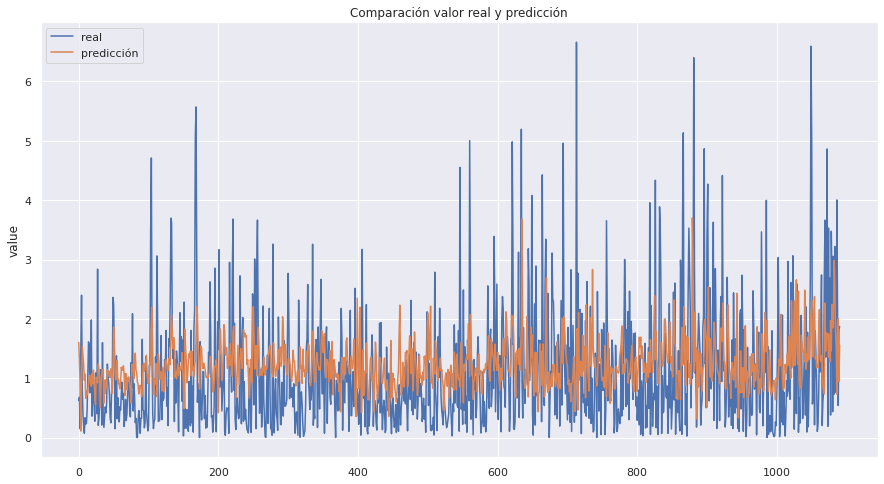

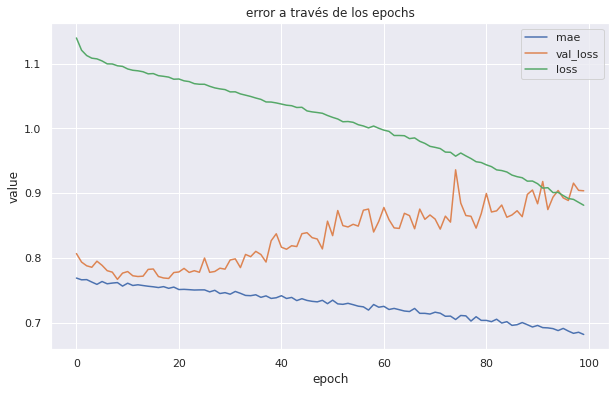

35/35 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.1314644071480382
MAE is : 0.780494373616552
RMSE is : 1.0637031574401
MAPE is : 38.714209865304625
Evaluation metric results:
MSE is : 1.0683393057451618
MAE is : 0.7932739603004132
RMSE is : 1.033605004702068
MAPE is : 43.12522665763359
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 5s 18ms/step - loss: 1.1400 - mae: 0.7702 - val_loss: 0.8013 - val_mae: 0.7074
Epoch 2/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1200 - mae: 0.7666 - val_loss: 0.7826 - val_mae: 0.6923
Epoch 3/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1110 - mae: 0.7663 - val_loss: 0.7785 - val_mae: 0.6914
Epoch 4/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1058 - mae: 0.7625 - val_loss: 0.7775 - val_mae: 0.6911
Epoch 5/100
128/128 [==============================] - 2s 13ms/step - loss: 1.1054 - mae:

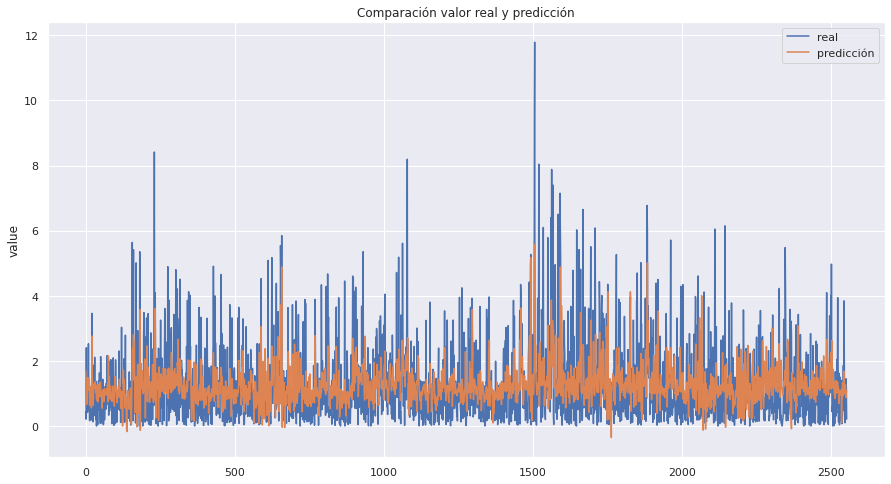

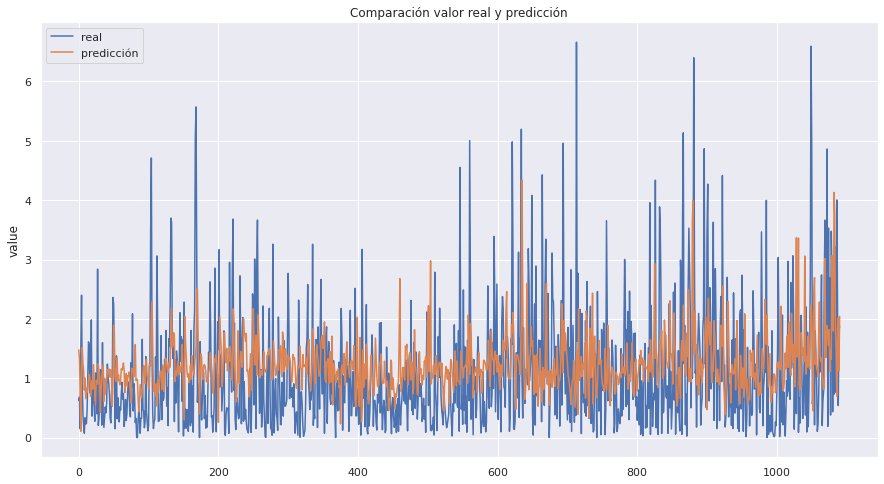

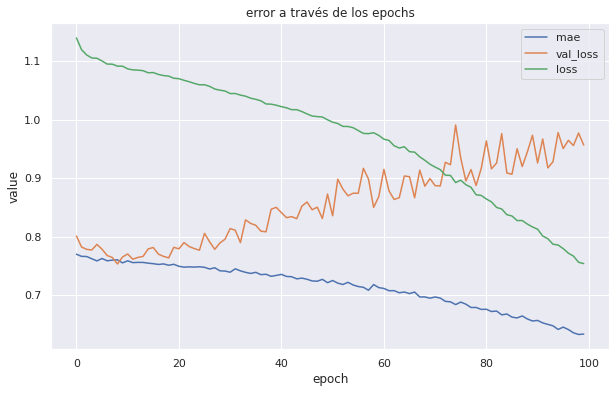

35/35 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 0.9957000515906952
MAE is : 0.7282186133911884
RMSE is : 0.9978477096184042
MAPE is : 36.23322024095761
Evaluation metric results:
MSE is : 1.2006293101760603
MAE is : 0.8258781145836337
RMSE is : 1.0957323168438815
MAPE is : 44.66664251298702
(2552, 5, 4) (2552, 1)
(1091, 5, 4) (1091, 1)
Epoch 1/100
128/128 [==============================] - 7s 33ms/step - loss: 1.1403 - mae: 0.7697 - val_loss: 0.7989 - val_mae: 0.7062
Epoch 2/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1185 - mae: 0.7657 - val_loss: 0.7745 - val_mae: 0.6873
Epoch 3/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1084 - mae: 0.7646 - val_loss: 0.7702 - val_mae: 0.6862
Epoch 4/100
128/128 [==============================] - 3s 24ms/step - loss: 1.1021 - mae: 0.7610 - val_loss: 0.7713 - val_mae: 0.6879
Epoch 5/100
128/128 [==============================] - 3s 23ms/step - loss: 1.1030 - 

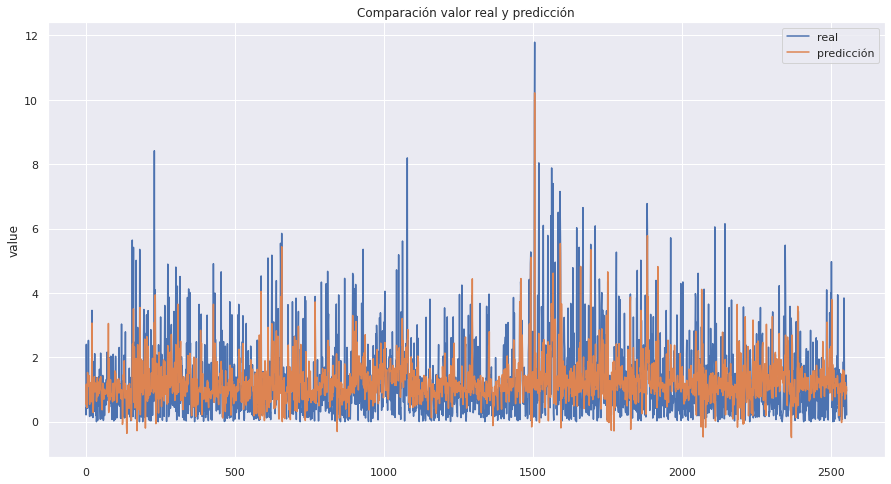

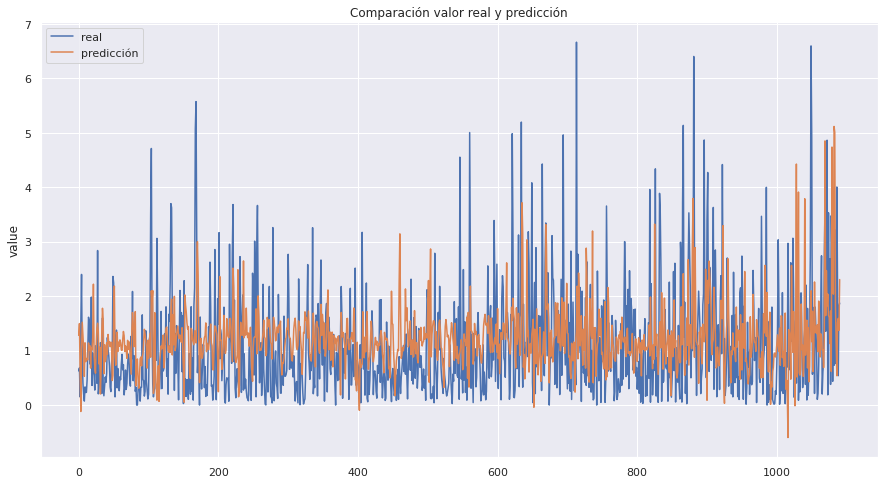

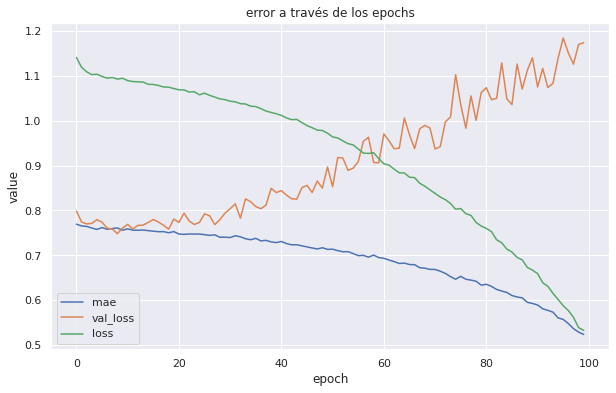

35/35 [==============================] - 0s 9ms/step
Evaluation metric results:
MSE is : 0.8038559808185997
MAE is : 0.6332517774998901
RMSE is : 0.8965801586130487
MAPE is : 32.141127995919895
Evaluation metric results:
MSE is : 1.4345055795848591
MAE is : 0.9065525774503828
RMSE is : 1.1977084701983447
MAPE is : 49.19573322237809


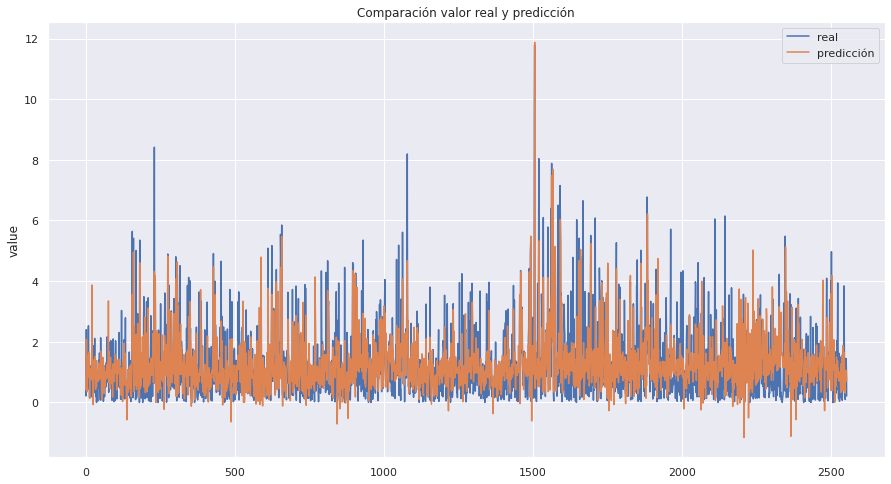

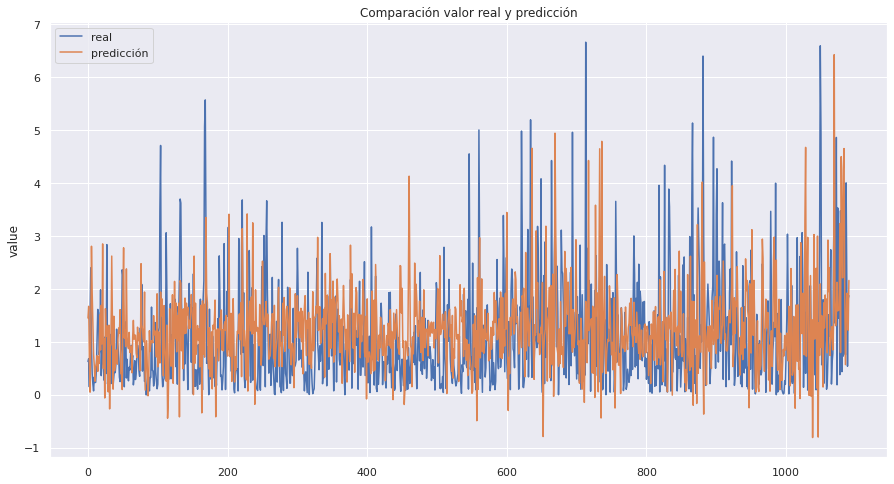

In [22]:
neuronss=[16,32,64,128,256,512]
results_model_lag5_epohs100=[]
for neuron in neuronss:
    results_model_lag5_epohs100.append(Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=4,epochss=100,batch_sizze=16,lag=5))

(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 11ms/step - loss: 1.2133 - mae: 0.7742 - val_loss: 0.8490 - val_mae: 0.7317
Epoch 2/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1729 - mae: 0.7740 - val_loss: 0.8410 - val_mae: 0.7318
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1550 - mae: 0.7744 - val_loss: 0.8316 - val_mae: 0.7269
Epoch 4/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1434 - mae: 0.7716 - val_loss: 0.8283 - val_mae: 0.7265
Epoch 5/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1356 - mae: 0.7689 - val_loss: 0.8263 - val_mae: 0.7256
Epoch 6/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1293 - mae: 0.7709 - val_loss: 0.8239 - val_mae: 0.7239
Epoch 7/100
128/128 [==============================] - 1s 7ms/step - loss: 1.1253 - mae: 0.7690 - val_loss: 0.8213 - val_mae: 0.7218
Epoch 8/100
128/128 [=

Epoch 62/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0512 - mae: 0.7447 - val_loss: 0.8134 - val_mae: 0.7275
Epoch 63/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0503 - mae: 0.7408 - val_loss: 0.8186 - val_mae: 0.7319
Epoch 64/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0493 - mae: 0.7445 - val_loss: 0.8063 - val_mae: 0.7216
Epoch 65/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0493 - mae: 0.7406 - val_loss: 0.8049 - val_mae: 0.7208
Epoch 66/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0472 - mae: 0.7383 - val_loss: 0.8115 - val_mae: 0.7260
Epoch 67/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0468 - mae: 0.7433 - val_loss: 0.8125 - val_mae: 0.7266
Epoch 68/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0456 - mae: 0.7384 - val_loss: 0.8172 - val_mae: 0.7303
Epoch 69/100
128/128 [==============================] - 1s 7ms

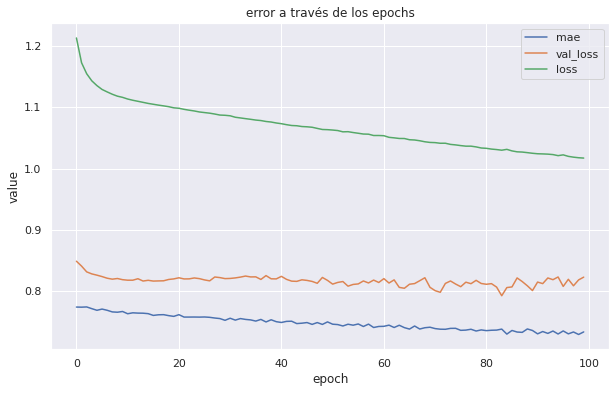

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2642051548604027
MAE is : 0.8317231928191293
RMSE is : 1.1243687806322278
MAPE is : 41.67888487989203
Evaluation metric results:
MSE is : 0.9637460889577438
MAE is : 0.7491264462707169
RMSE is : 0.9817057038429307
MAPE is : 40.58628761288188
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 13ms/step - loss: 1.1359 - mae: 0.7579 - val_loss: 0.7925 - val_mae: 0.6922
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1203 - mae: 0.7618 - val_loss: 0.8031 - val_mae: 0.7063
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1156 - mae: 0.7638 - val_loss: 0.7967 - val_mae: 0.6994
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1123 - mae: 0.7618 - val_loss: 0.8012 - val_mae: 0.7054
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1091 - mae:

Epoch 59/100
128/128 [==============================] - 1s 7ms/step - loss: 1.0397 - mae: 0.7336 - val_loss: 0.8154 - val_mae: 0.7294
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0403 - mae: 0.7356 - val_loss: 0.8074 - val_mae: 0.7233
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0408 - mae: 0.7375 - val_loss: 0.8241 - val_mae: 0.7361
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0375 - mae: 0.7390 - val_loss: 0.8070 - val_mae: 0.7221
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0363 - mae: 0.7334 - val_loss: 0.8211 - val_mae: 0.7333
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0354 - mae: 0.7389 - val_loss: 0.7996 - val_mae: 0.7155
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0354 - mae: 0.7338 - val_loss: 0.7964 - val_mae: 0.7129
Epoch 66/100
128/128 [==============================] - 1s 8ms

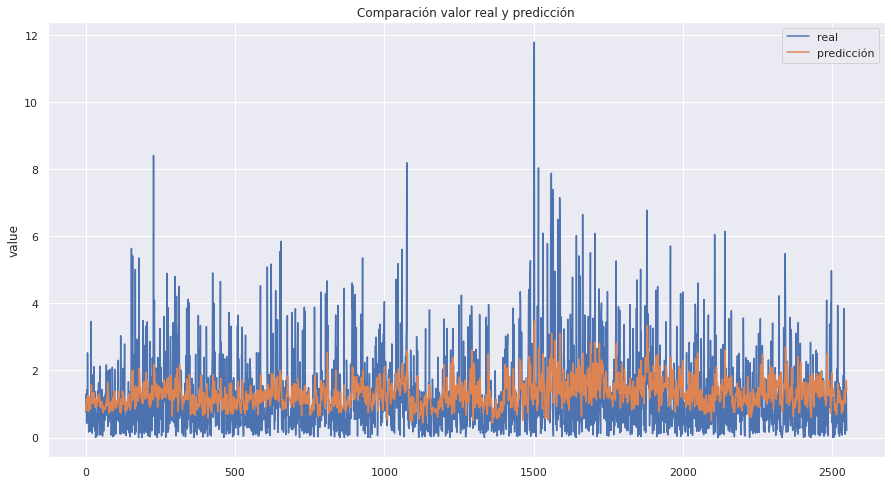

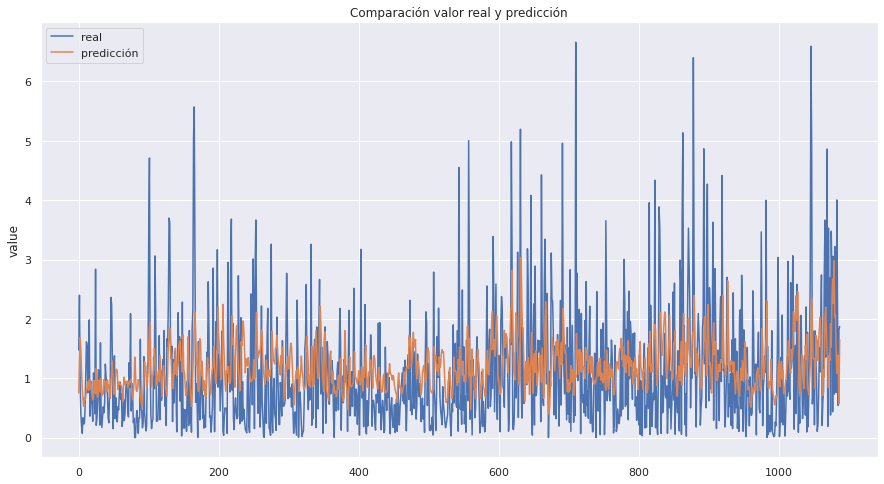

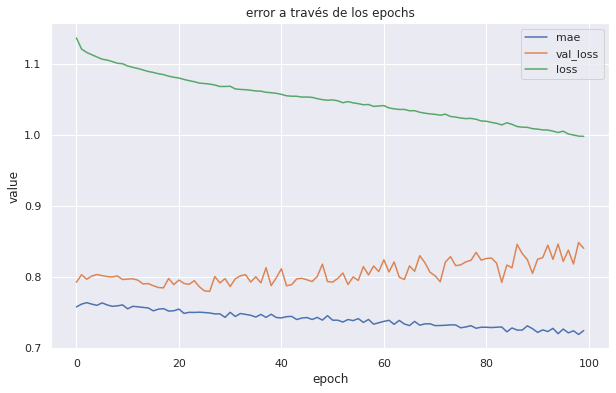

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.2451036474003327
MAE is : 0.8216069800460197
RMSE is : 1.1158421247651178
MAPE is : 41.188904556225154
Evaluation metric results:
MSE is : 0.99563924080768
MAE is : 0.7684867471732865
RMSE is : 0.9978172381792569
MAPE is : 42.21152636427896
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 12ms/step - loss: 1.1542 - mae: 0.7653 - val_loss: 0.8006 - val_mae: 0.7006
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1255 - mae: 0.7657 - val_loss: 0.8100 - val_mae: 0.7131
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1198 - mae: 0.7666 - val_loss: 0.7962 - val_mae: 0.6988
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1144 - mae: 0.7633 - val_loss: 0.8041 - val_mae: 0.7112
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1084 - mae: 

Epoch 59/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0080 - mae: 0.7221 - val_loss: 0.8473 - val_mae: 0.7413
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0089 - mae: 0.7248 - val_loss: 0.8316 - val_mae: 0.7303
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0078 - mae: 0.7256 - val_loss: 0.8512 - val_mae: 0.7425
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0031 - mae: 0.7266 - val_loss: 0.8253 - val_mae: 0.7234
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 0.9999 - mae: 0.7208 - val_loss: 0.8536 - val_mae: 0.7434
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 0.9966 - mae: 0.7249 - val_loss: 0.8153 - val_mae: 0.7112
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 0.9976 - mae: 0.7214 - val_loss: 0.8096 - val_mae: 0.7073
Epoch 66/100
128/128 [==============================] - 1s 8ms

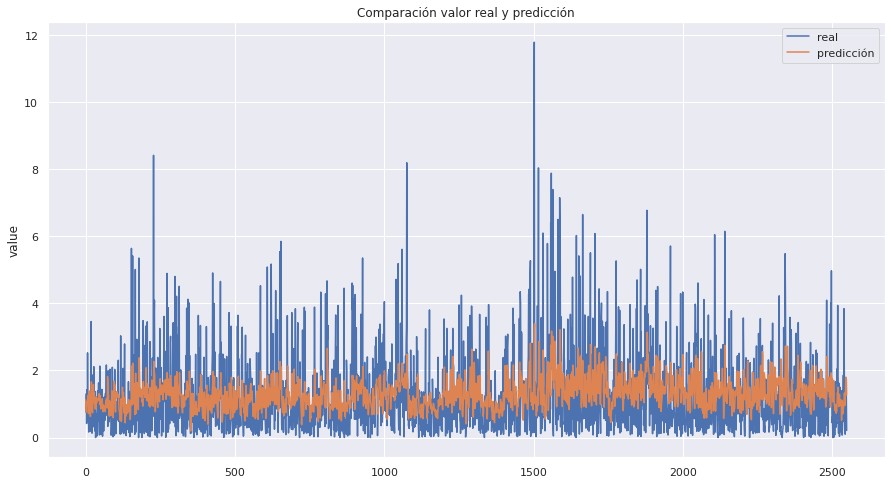

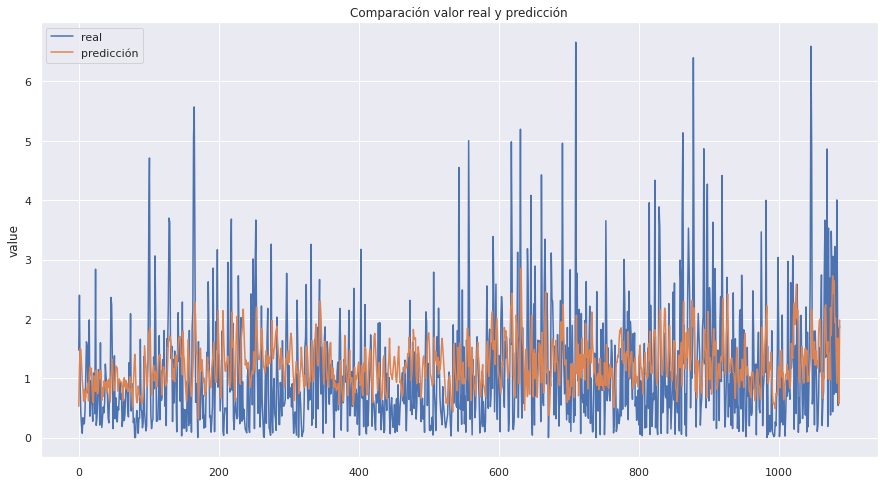

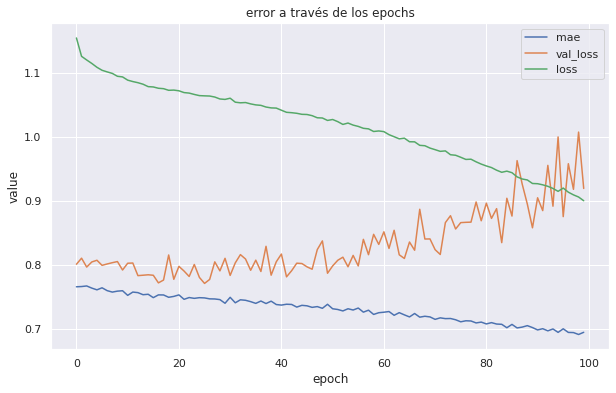

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.158564884580806
MAE is : 0.7886303093442638
RMSE is : 1.076366519630189
MAPE is : 38.97404566113051
Evaluation metric results:
MSE is : 1.0442991446978647
MAE is : 0.7697490883237643
RMSE is : 1.0219095579834179
MAPE is : 40.2755802781504
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 4s 15ms/step - loss: 1.1419 - mae: 0.7640 - val_loss: 0.8030 - val_mae: 0.7000
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1234 - mae: 0.7652 - val_loss: 0.8083 - val_mae: 0.7084
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1178 - mae: 0.7670 - val_loss: 0.7923 - val_mae: 0.6954
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1104 - mae: 0.7611 - val_loss: 0.8005 - val_mae: 0.7086
Epoch 5/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1020 - mae

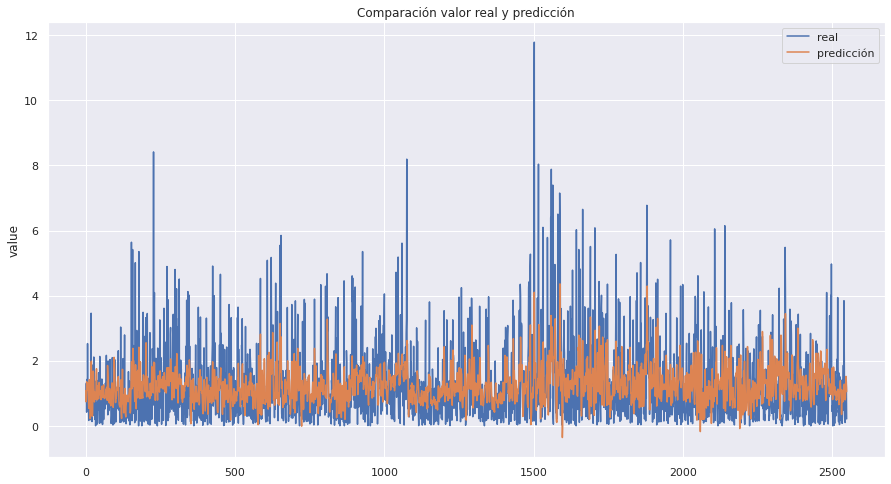

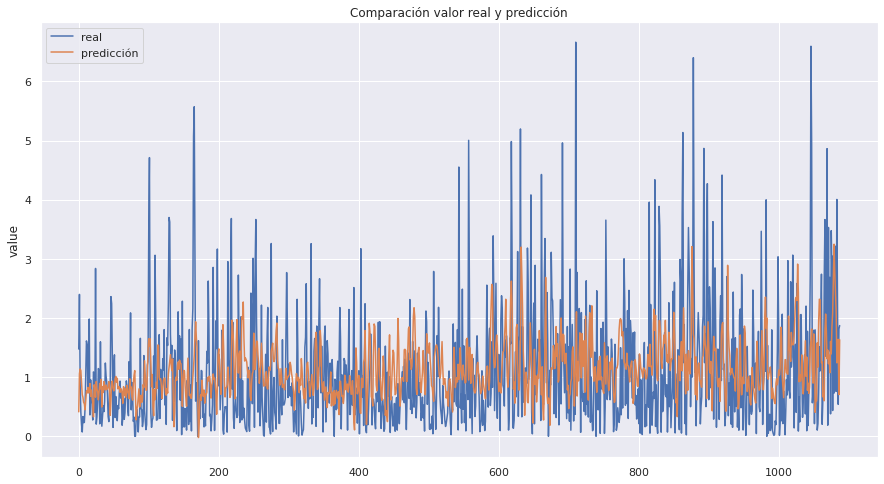

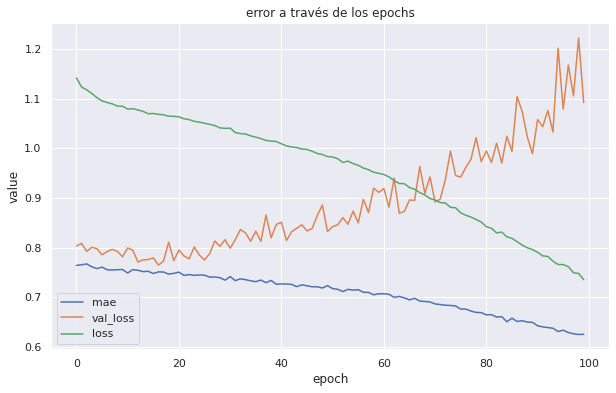

34/34 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.0223306174961264
MAE is : 0.7326956133141477
RMSE is : 1.0111036630811534
MAPE is : 36.69803314449693
Evaluation metric results:
MSE is : 1.1370145208703653
MAE is : 0.806687370903252
RMSE is : 1.066308829969238
MAPE is : 43.08447680192706
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 5s 22ms/step - loss: 1.1375 - mae: 0.7654 - val_loss: 0.7967 - val_mae: 0.7023
Epoch 2/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1170 - mae: 0.7635 - val_loss: 0.7909 - val_mae: 0.6975
Epoch 3/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1105 - mae: 0.7638 - val_loss: 0.7753 - val_mae: 0.6912
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1020 - mae: 0.7578 - val_loss: 0.7859 - val_mae: 0.7044
Epoch 5/100
128/128 [==============================] - 2s 17ms/step - loss: 1.0929 - ma

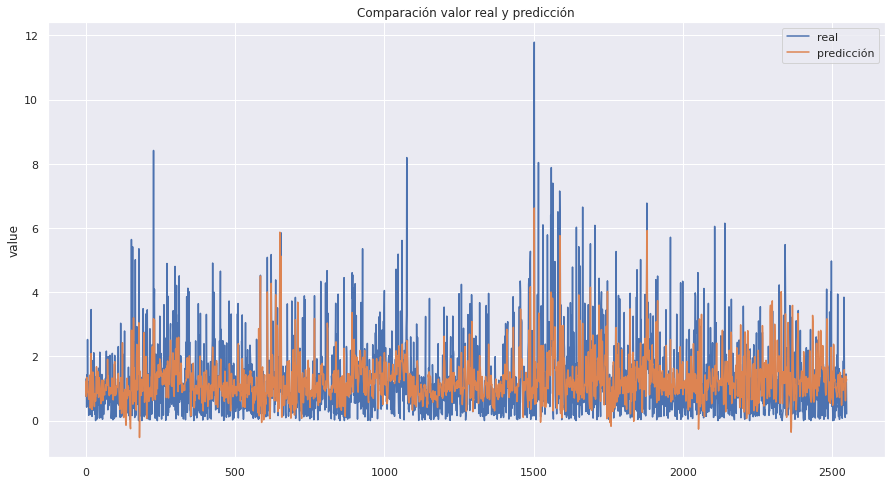

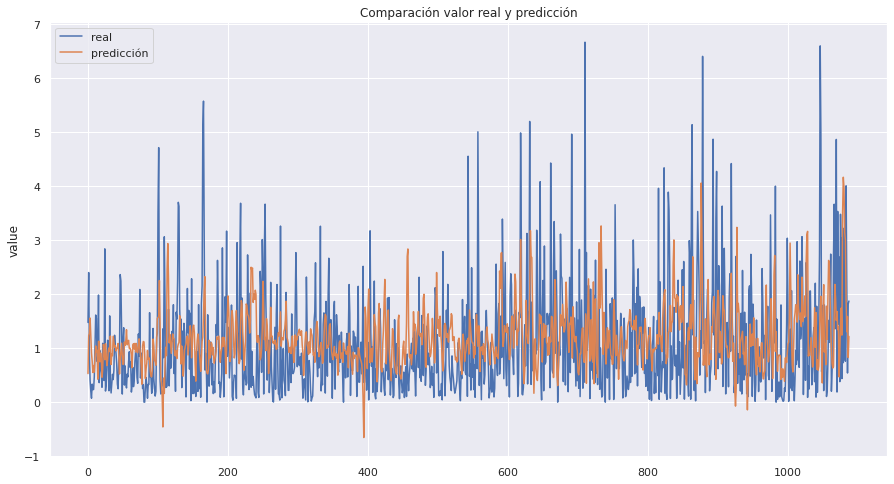

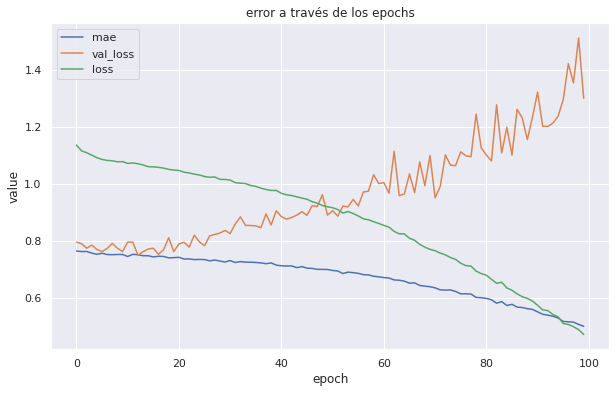

34/34 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 0.7947795246954633
MAE is : 0.6349747273988794
RMSE is : 0.8915040800217705
MAPE is : 32.34681298506211
Evaluation metric results:
MSE is : 1.4331789805332178
MAE is : 0.8923304539669868
RMSE is : 1.1971545349424266
MAPE is : 47.82956586466524
(2549, 8, 4) (2549, 1)
(1088, 8, 4) (1088, 1)
Epoch 1/100
128/128 [==============================] - 7s 35ms/step - loss: 1.1384 - mae: 0.7651 - val_loss: 0.7871 - val_mae: 0.6989
Epoch 2/100
128/128 [==============================] - 4s 31ms/step - loss: 1.1102 - mae: 0.7609 - val_loss: 0.7755 - val_mae: 0.6856
Epoch 3/100
128/128 [==============================] - 4s 31ms/step - loss: 1.1019 - mae: 0.7606 - val_loss: 0.7641 - val_mae: 0.6870
Epoch 4/100
128/128 [==============================] - 4s 31ms/step - loss: 1.0950 - mae: 0.7555 - val_loss: 0.7739 - val_mae: 0.6964
Epoch 5/100
128/128 [==============================] - 4s 31ms/step - loss: 1.0872 - 

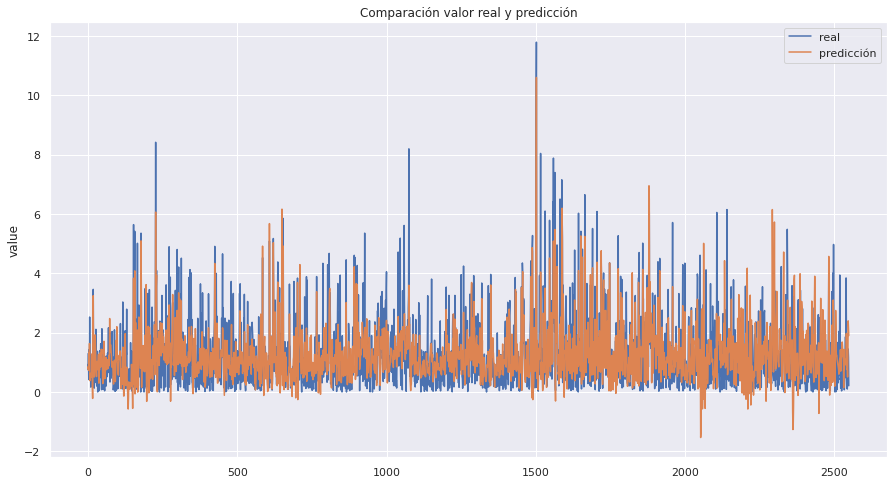

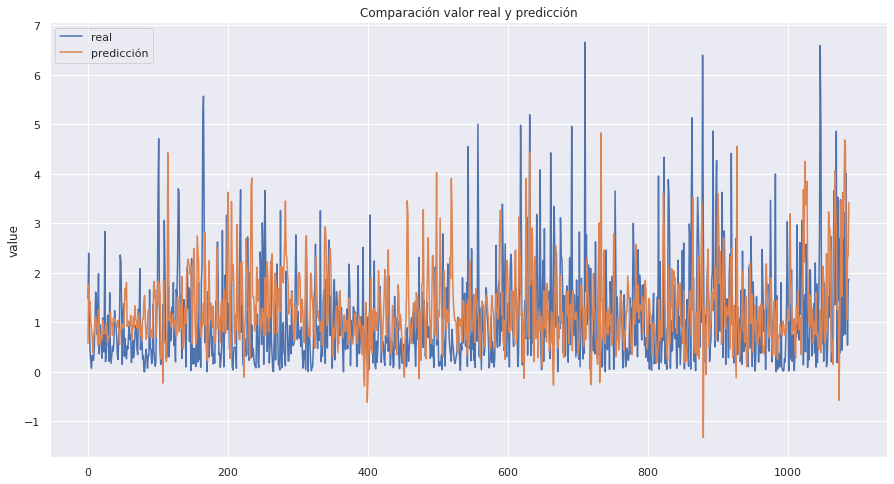

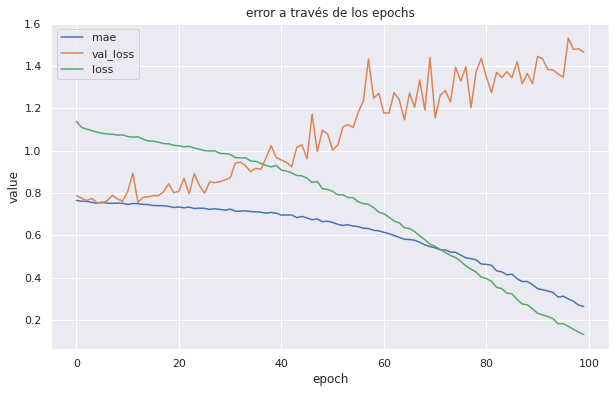

34/34 [==============================] - 0s 13ms/step
Evaluation metric results:
MSE is : 0.5171587772122297
MAE is : 0.4490842268544191
RMSE is : 0.7191375231568922
MAPE is : 23.775679686384475
Evaluation metric results:
MSE is : 1.6246143734018206
MAE is : 0.9452891948186448
RMSE is : 1.274603614227506
MAPE is : 50.09416578435645


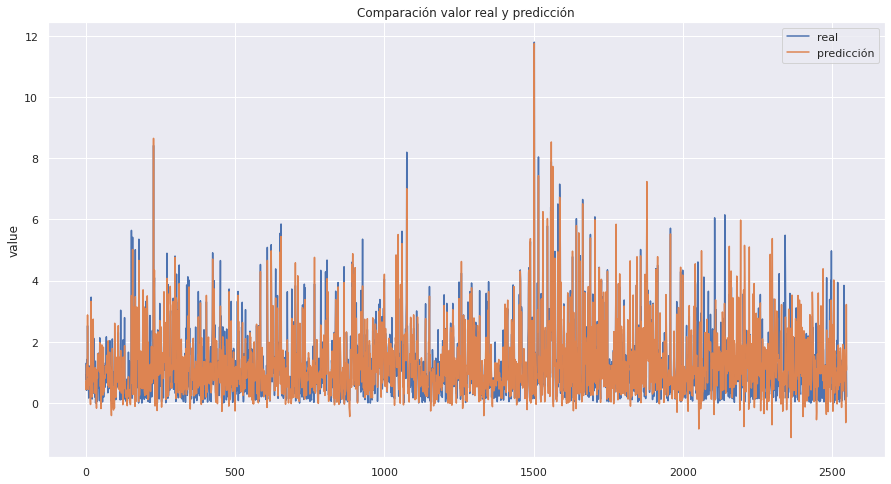

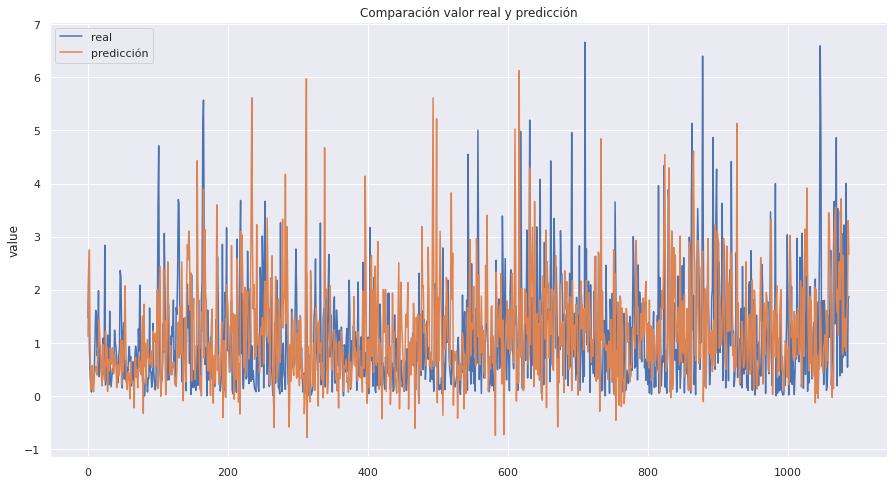

In [24]:
neuronss=[16,32,64,128,256,512]
results_model_lag8_epohs100=[]
for neuron in neuronss:
    results_model_lag8_epohs100.append(Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=4,epochss=100,batch_sizze=16,lag=8))

(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1932 - mae: 0.7874 - val_loss: 0.8321 - val_mae: 0.7188
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1558 - mae: 0.7757 - val_loss: 0.8319 - val_mae: 0.7232
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1420 - mae: 0.7722 - val_loss: 0.8272 - val_mae: 0.7210
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1339 - mae: 0.7717 - val_loss: 0.8238 - val_mae: 0.7190
Epoch 5/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1280 - mae: 0.7658 - val_loss: 0.8207 - val_mae: 0.7175
Epoch 6/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1230 - mae: 0.7650 - val_loss: 0.8176 - val_mae: 0.7160
Epoch 7/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1189 - mae: 0.7660 - val_loss: 0.8142 - val_mae: 0.7138
Epoch 8/100
128/128 

Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0533 - mae: 0.7454 - val_loss: 0.7922 - val_mae: 0.7130
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0540 - mae: 0.7426 - val_loss: 0.7976 - val_mae: 0.7183
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0520 - mae: 0.7460 - val_loss: 0.7925 - val_mae: 0.7132
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0516 - mae: 0.7409 - val_loss: 0.7991 - val_mae: 0.7199
Epoch 66/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0504 - mae: 0.7434 - val_loss: 0.7935 - val_mae: 0.7146
Epoch 67/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0494 - mae: 0.7412 - val_loss: 0.7975 - val_mae: 0.7182
Epoch 68/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0487 - mae: 0.7437 - val_loss: 0.7948 - val_mae: 0.7158
Epoch 69/100
128/128 [==============================] - 1s 9ms

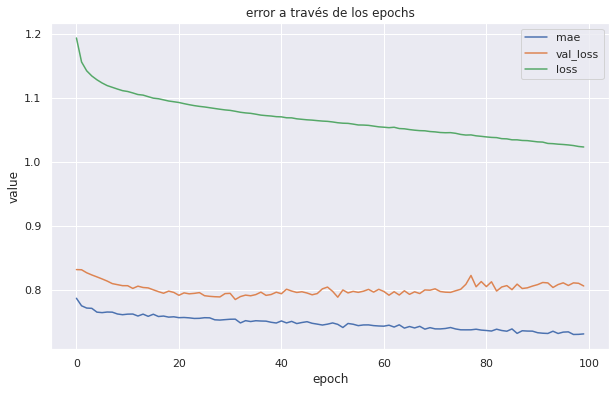

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.26718487398883
MAE is : 0.8294787845438976
RMSE is : 1.1256930638450386
MAPE is : 41.501667698971474
Evaluation metric results:
MSE is : 0.9685350205374275
MAE is : 0.7463856702045423
RMSE is : 0.9841417685158107
MAPE is : 39.97602775359588
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 4s 13ms/step - loss: 1.1313 - mae: 0.7671 - val_loss: 0.8012 - val_mae: 0.7047
Epoch 2/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1196 - mae: 0.7668 - val_loss: 0.8032 - val_mae: 0.7068
Epoch 3/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1159 - mae: 0.7667 - val_loss: 0.8015 - val_mae: 0.7057
Epoch 4/100
128/128 [==============================] - 1s 8ms/step - loss: 1.1126 - mae: 0.7684 - val_loss: 0.8026 - val_mae: 0.7082
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1102 - mae

Epoch 59/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0364 - mae: 0.7386 - val_loss: 0.7980 - val_mae: 0.7155
Epoch 60/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0340 - mae: 0.7373 - val_loss: 0.8030 - val_mae: 0.7194
Epoch 61/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0320 - mae: 0.7362 - val_loss: 0.7958 - val_mae: 0.7124
Epoch 62/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0309 - mae: 0.7389 - val_loss: 0.7890 - val_mae: 0.7046
Epoch 63/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0309 - mae: 0.7343 - val_loss: 0.7995 - val_mae: 0.7159
Epoch 64/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0263 - mae: 0.7372 - val_loss: 0.7965 - val_mae: 0.7124
Epoch 65/100
128/128 [==============================] - 1s 8ms/step - loss: 1.0254 - mae: 0.7318 - val_loss: 0.7940 - val_mae: 0.7097
Epoch 66/100
128/128 [==============================] - 1s 9ms

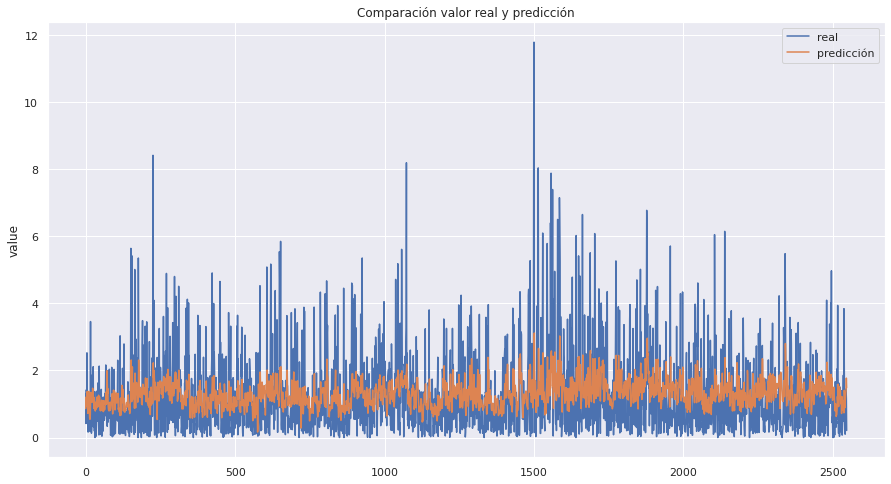

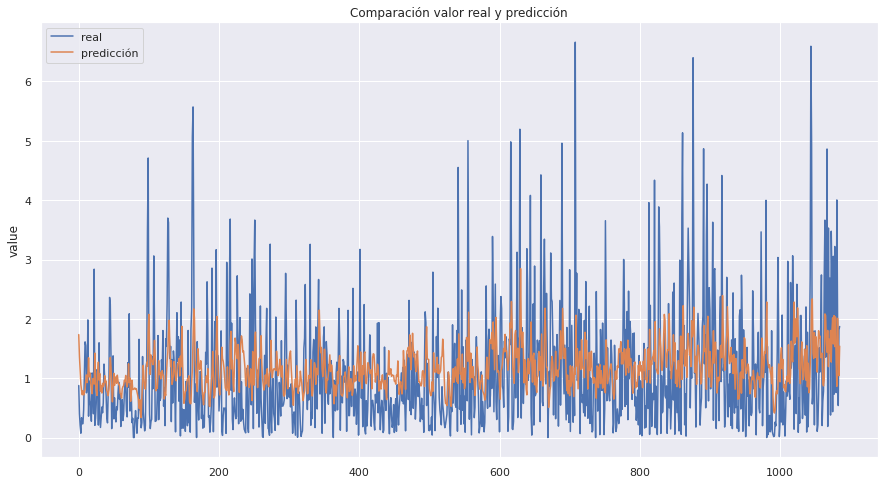

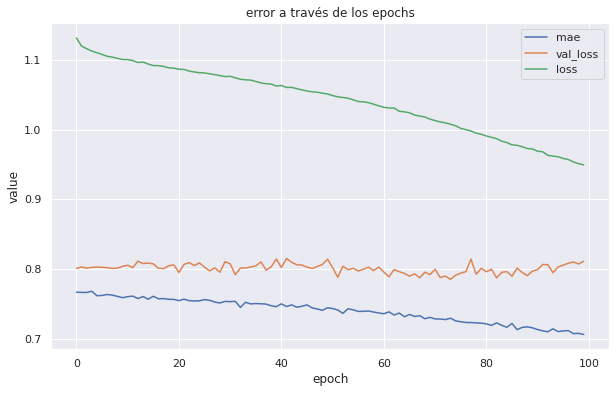

34/34 [==============================] - 0s 3ms/step
Evaluation metric results:
MSE is : 1.1861566827658376
MAE is : 0.8024233378364459
RMSE is : 1.0891082052605414
MAPE is : 40.01402562139805
Evaluation metric results:
MSE is : 0.9978647955055556
MAE is : 0.753787305565098
RMSE is : 0.9989318272562726
MAPE is : 39.85268472534364
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 5s 14ms/step - loss: 1.1349 - mae: 0.7652 - val_loss: 0.8069 - val_mae: 0.7083
Epoch 2/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1219 - mae: 0.7674 - val_loss: 0.8064 - val_mae: 0.7096
Epoch 3/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1169 - mae: 0.7654 - val_loss: 0.7994 - val_mae: 0.7032
Epoch 4/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1130 - mae: 0.7679 - val_loss: 0.8014 - val_mae: 0.7070
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 1.1096 - mae

Epoch 59/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9618 - mae: 0.7107 - val_loss: 0.8202 - val_mae: 0.7182
Epoch 60/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9588 - mae: 0.7088 - val_loss: 0.8399 - val_mae: 0.7315
Epoch 61/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9559 - mae: 0.7089 - val_loss: 0.8209 - val_mae: 0.7160
Epoch 62/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9526 - mae: 0.7088 - val_loss: 0.8110 - val_mae: 0.7071
Epoch 63/100
128/128 [==============================] - 1s 10ms/step - loss: 0.9536 - mae: 0.7055 - val_loss: 0.8214 - val_mae: 0.7175
Epoch 64/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9438 - mae: 0.7046 - val_loss: 0.8515 - val_mae: 0.7346
Epoch 65/100
128/128 [==============================] - 1s 9ms/step - loss: 0.9437 - mae: 0.7030 - val_loss: 0.8298 - val_mae: 0.7226
Epoch 66/100
128/128 [==============================] - 1s 9m

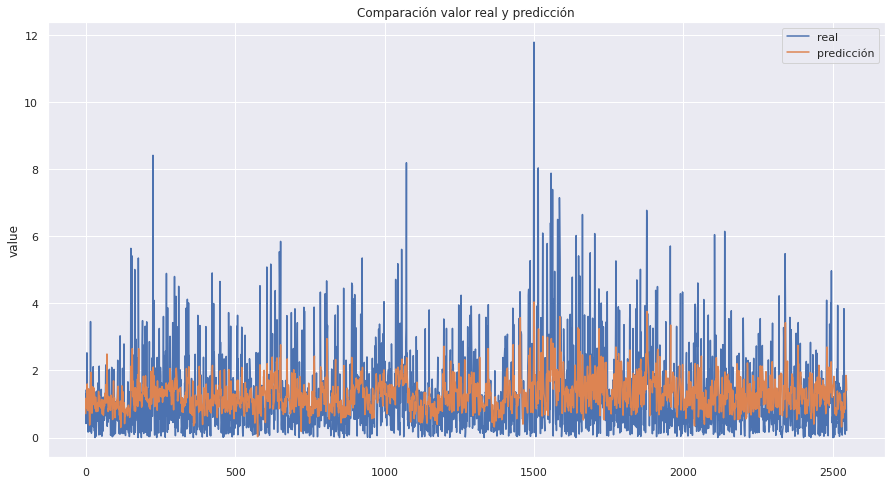

128/128 [==============================] - 2s 12ms/step - loss: 1.1017 - mae: 0.7584 - val_loss: 0.7930 - val_mae: 0.7070
Epoch 7/100
128/128 [==============================] - 2s 12ms/step - loss: 1.0960 - mae: 0.7604 - val_loss: 0.7870 - val_mae: 0.7009
Epoch 8/100
128/128 [==============================] - 2s 12ms/step - loss: 1.0941 - mae: 0.7572 - val_loss: 0.7842 - val_mae: 0.6999
Epoch 9/100
128/128 [==============================] - 2s 12ms/step - loss: 1.0891 - mae: 0.7559 - val_loss: 0.7746 - val_mae: 0.6892
Epoch 10/100
128/128 [==============================] - 2s 12ms/step - loss: 1.0861 - mae: 0.7524 - val_loss: 0.7960 - val_mae: 0.7162
Epoch 11/100
128/128 [==============================] - 2s 12ms/step - loss: 1.0850 - mae: 0.7549 - val_loss: 0.7847 - val_mae: 0.7064
Epoch 12/100
128/128 [==============================] - 2s 12ms/step - loss: 1.0836 - mae: 0.7535 - val_loss: 0.7859 - val_mae: 0.7070
Epoch 13/100
128/128 [==============================] - 1s 12ms/step - 

Epoch 67/100
128/128 [==============================] - 2s 12ms/step - loss: 0.8296 - mae: 0.6634 - val_loss: 1.0002 - val_mae: 0.7750
Epoch 68/100
128/128 [==============================] - 2s 12ms/step - loss: 0.8233 - mae: 0.6586 - val_loss: 1.0162 - val_mae: 0.7776
Epoch 69/100
128/128 [==============================] - 2s 12ms/step - loss: 0.8196 - mae: 0.6532 - val_loss: 1.0154 - val_mae: 0.7767
Epoch 70/100
128/128 [==============================] - 2s 12ms/step - loss: 0.8063 - mae: 0.6524 - val_loss: 1.0330 - val_mae: 0.7843
Epoch 71/100
128/128 [==============================] - 2s 12ms/step - loss: 0.7983 - mae: 0.6476 - val_loss: 1.1618 - val_mae: 0.8426
Epoch 72/100
128/128 [==============================] - 2s 12ms/step - loss: 0.7915 - mae: 0.6453 - val_loss: 1.0914 - val_mae: 0.8054
Epoch 73/100
128/128 [==============================] - 2s 12ms/step - loss: 0.7833 - mae: 0.6423 - val_loss: 1.0953 - val_mae: 0.8066
Epoch 74/100
128/128 [==============================] -

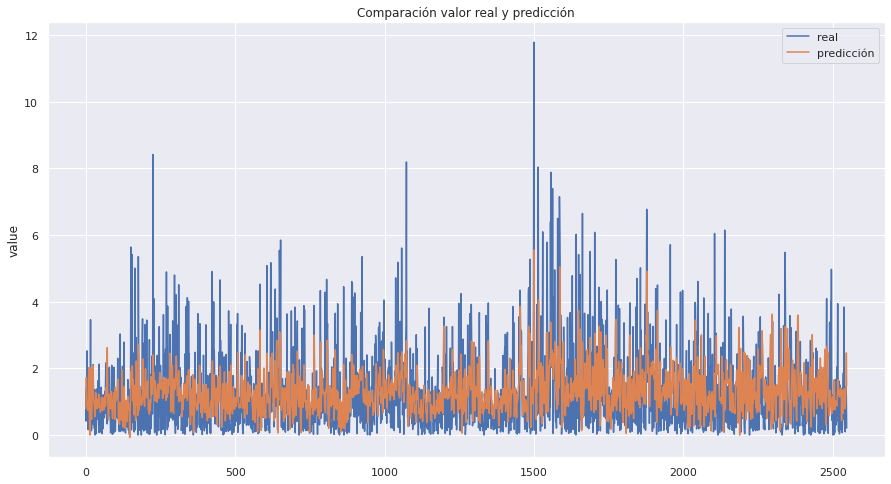

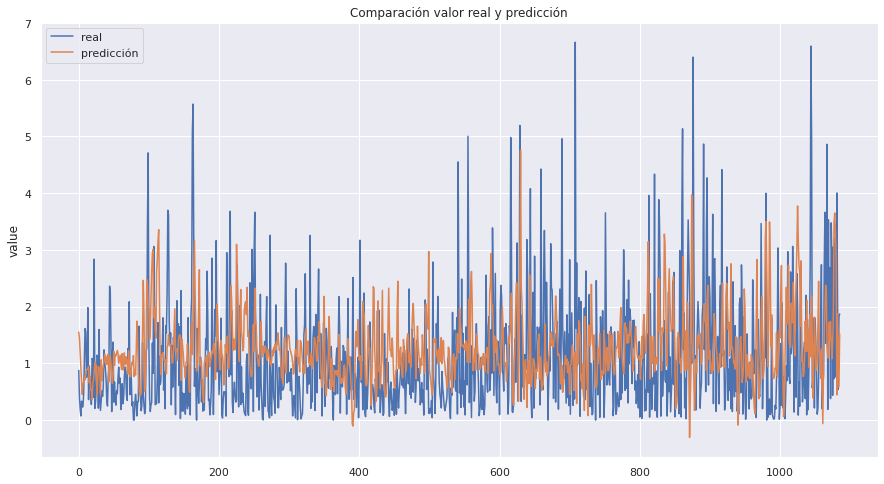

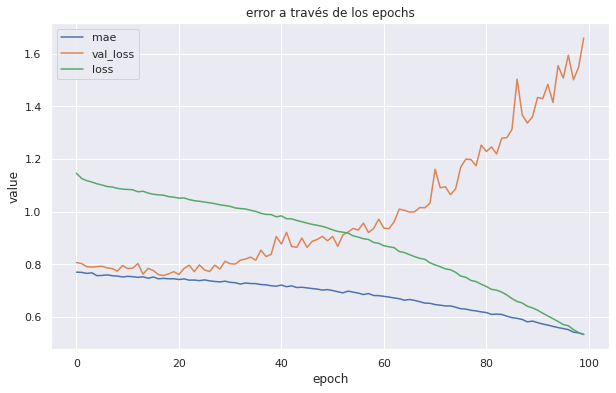

34/34 [==============================] - 0s 6ms/step
Evaluation metric results:
MSE is : 0.9437762568494878
MAE is : 0.6911597880234192
RMSE is : 0.9714814752991885
MAPE is : 36.2348559848853
Evaluation metric results:
MSE is : 1.2862907375684165
MAE is : 0.8525712317573687
RMSE is : 1.134147581917105
MAPE is : 45.98896289995898
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 6s 25ms/step - loss: 1.1425 - mae: 0.7720 - val_loss: 0.7980 - val_mae: 0.6969
Epoch 2/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1200 - mae: 0.7680 - val_loss: 0.7927 - val_mae: 0.7013
Epoch 3/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1134 - mae: 0.7644 - val_loss: 0.7805 - val_mae: 0.6850
Epoch 4/100
128/128 [==============================] - 3s 20ms/step - loss: 1.1073 - mae: 0.7656 - val_loss: 0.7759 - val_mae: 0.6876
Epoch 5/100
128/128 [==============================] - 3s 20ms/step - loss: 1.0997 - 

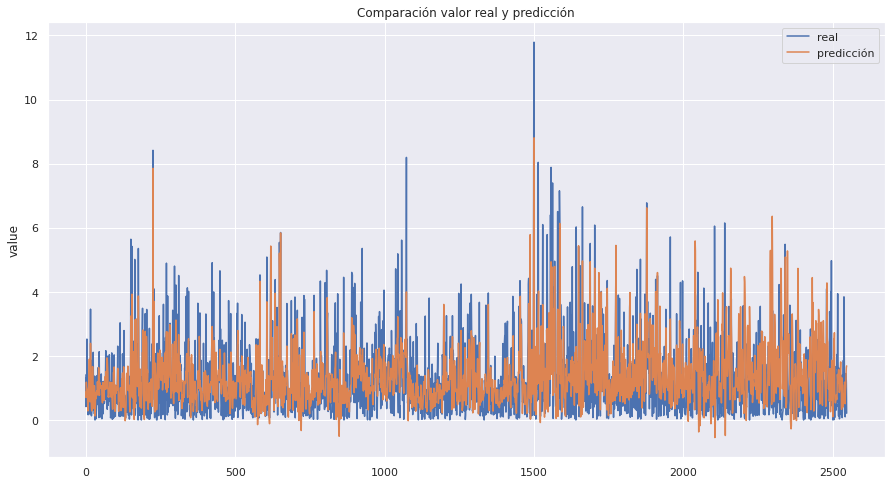

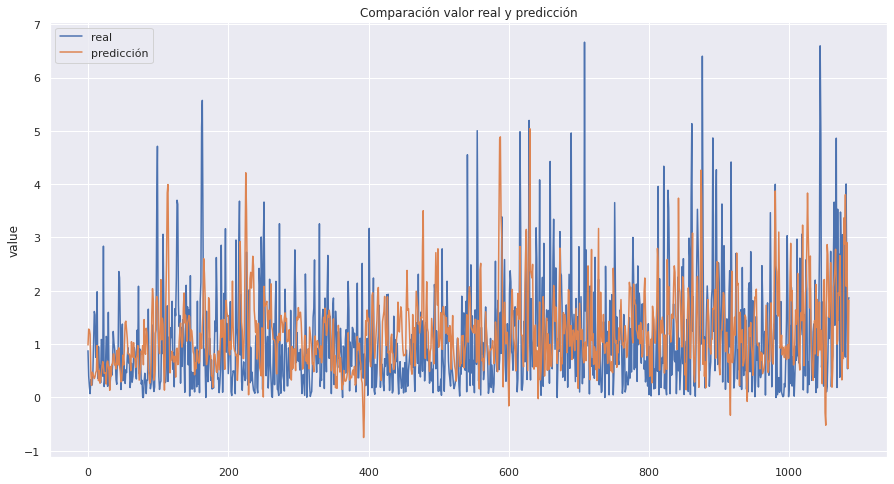

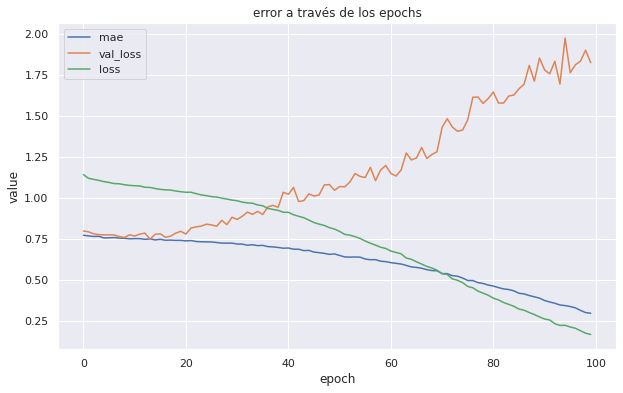

34/34 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 0.6249141975782462
MAE is : 0.480609638933681
RMSE is : 0.7905151469631978
MAPE is : 25.520277208051787
Evaluation metric results:
MSE is : 1.6864332634604786
MAE is : 0.9577262255619435
RMSE is : 1.2986274536834952
MAPE is : 51.58753079461958
(2547, 10, 4) (2547, 1)
(1086, 10, 4) (1086, 1)
Epoch 1/100
128/128 [==============================] - 8s 42ms/step - loss: 1.1526 - mae: 0.7726 - val_loss: 0.7979 - val_mae: 0.6951
Epoch 2/100
128/128 [==============================] - 5s 37ms/step - loss: 1.1166 - mae: 0.7656 - val_loss: 0.7854 - val_mae: 0.6974
Epoch 3/100
128/128 [==============================] - 5s 37ms/step - loss: 1.1074 - mae: 0.7617 - val_loss: 0.7688 - val_mae: 0.6773
Epoch 4/100
128/128 [==============================] - 5s 38ms/step - loss: 1.0992 - mae: 0.7615 - val_loss: 0.7600 - val_mae: 0.6785
Epoch 5/100
128/128 [==============================] - 5s 37ms/step - loss: 1.0910 

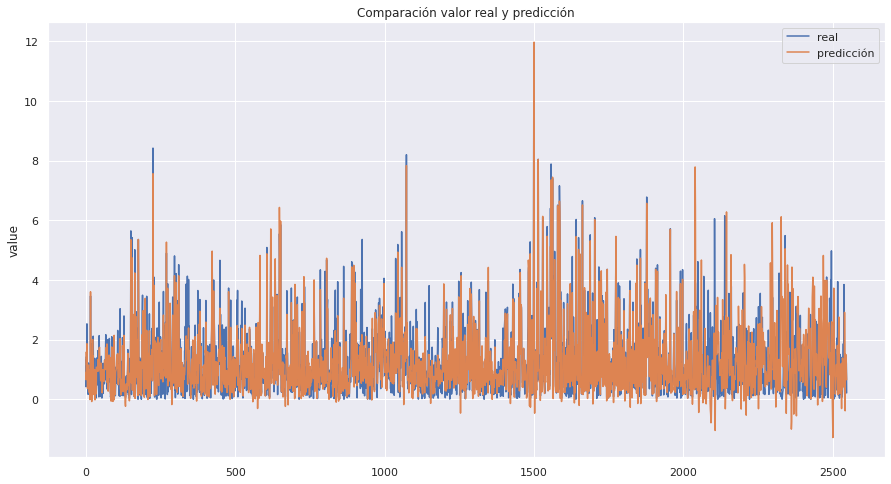

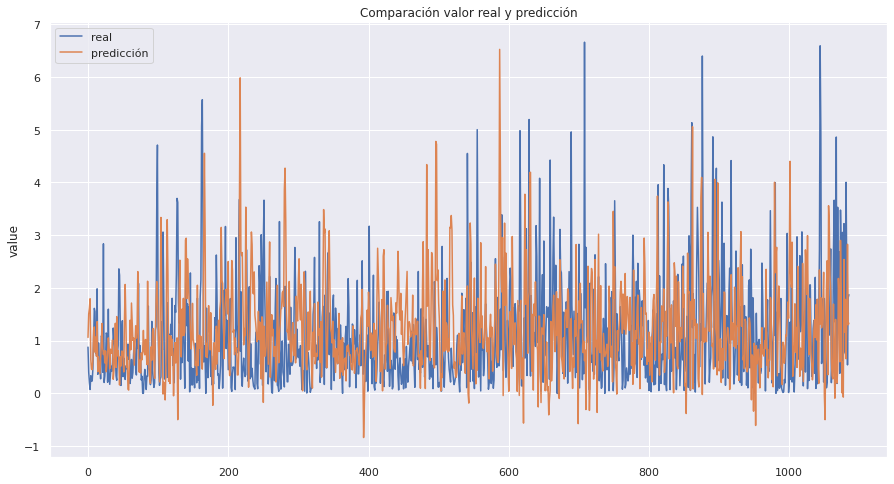

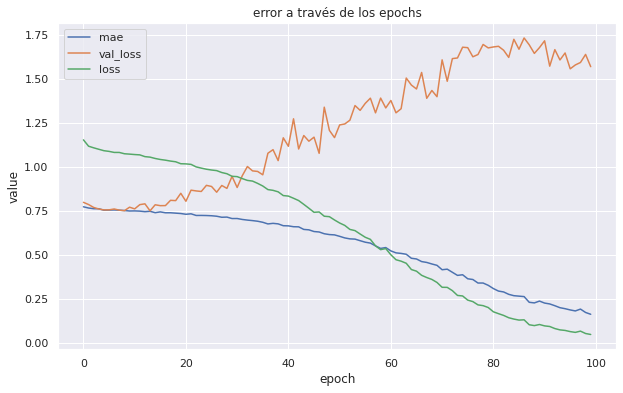

34/34 [==============================] - 1s 16ms/step
Evaluation metric results:
MSE is : 0.4524536607904984
MAE is : 0.3616012238553374
RMSE is : 0.6726467578086572
MAPE is : 18.93024937612844
Evaluation metric results:
MSE is : 1.5925279060325088
MAE is : 0.9536318264132293
RMSE is : 1.2619540031366074
MAPE is : 51.84458317270041


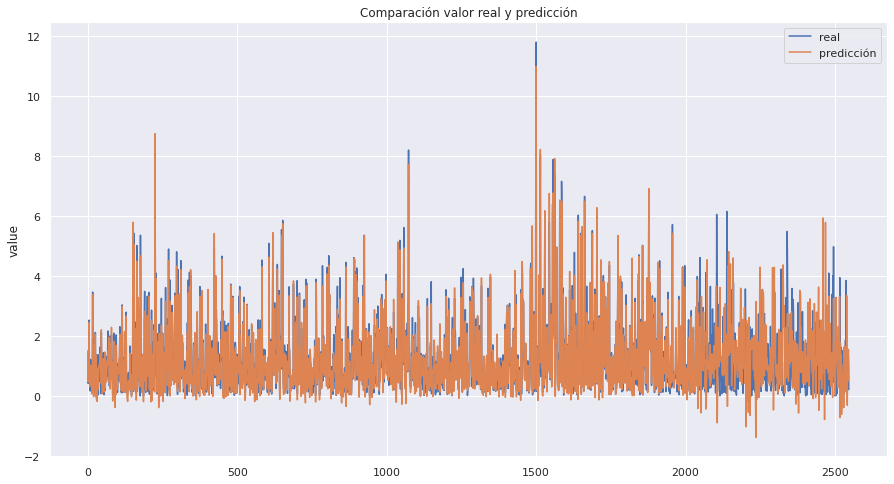

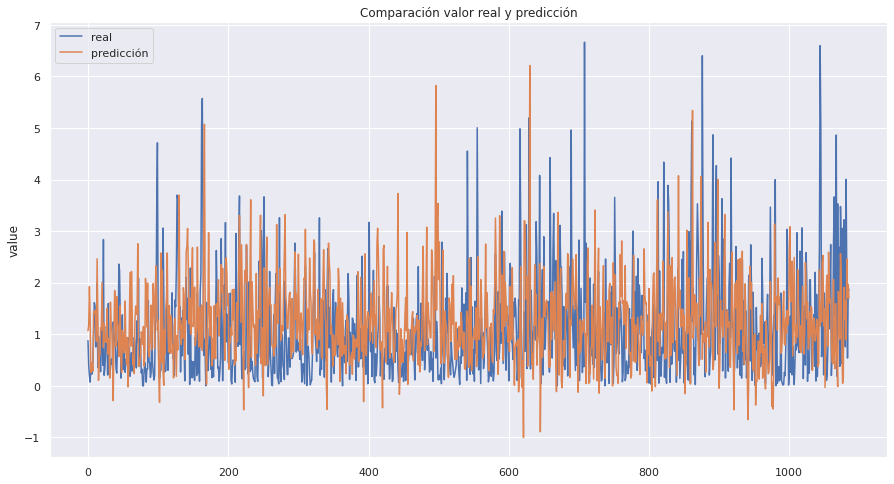

In [25]:
neuronss=[16,32,64,128,256,512]
results_model_lag10_epohs100=[]
for neuron in neuronss:
    results_model_lag10_epohs100.append(Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=4,epochss=100,batch_sizze=16,lag=10))

(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 16ms/step - loss: 1.1510 - mae: 0.7699 - val_loss: 0.8124 - val_mae: 0.7117
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1328 - mae: 0.7695 - val_loss: 0.8132 - val_mae: 0.7130
Epoch 3/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1248 - mae: 0.7647 - val_loss: 0.8140 - val_mae: 0.7139
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1185 - mae: 0.7668 - val_loss: 0.8129 - val_mae: 0.7127
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1147 - mae: 0.7645 - val_loss: 0.8148 - val_mae: 0.7147
Epoch 6/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1113 - mae: 0.7670 - val_loss: 0.8119 - val_mae: 0.7115
Epoch 7/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1089 - mae: 0.7630 - val_loss: 0.8092 - val_mae: 0.7093
Epoch 8/100
12

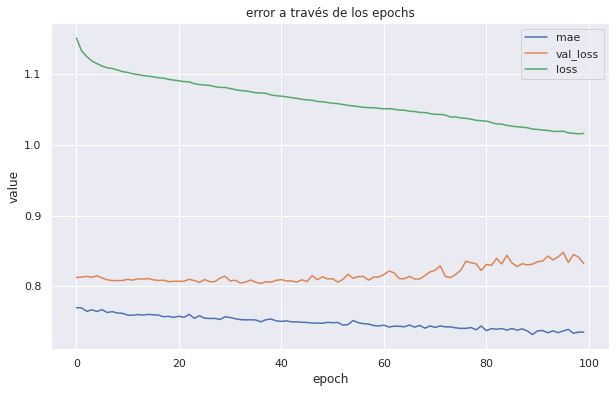

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.2648581912218158
MAE is : 0.8317126212577154
RMSE is : 1.1246591444619192
MAPE is : 41.43118686488279
Evaluation metric results:
MSE is : 1.012003592892244
MAE is : 0.7715105625989032
RMSE is : 1.0059838929586518
MAPE is : 41.64086855347161
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 4s 15ms/step - loss: 1.1751 - mae: 0.7770 - val_loss: 0.8322 - val_mae: 0.7229
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1387 - mae: 0.7746 - val_loss: 0.8237 - val_mae: 0.7176
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 1.1255 - mae: 0.7653 - val_loss: 0.8246 - val_mae: 0.7207
Epoch 4/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1176 - mae: 0.7688 - val_loss: 0.8198 - val_mae: 0.7169
Epoch 5/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1129 -

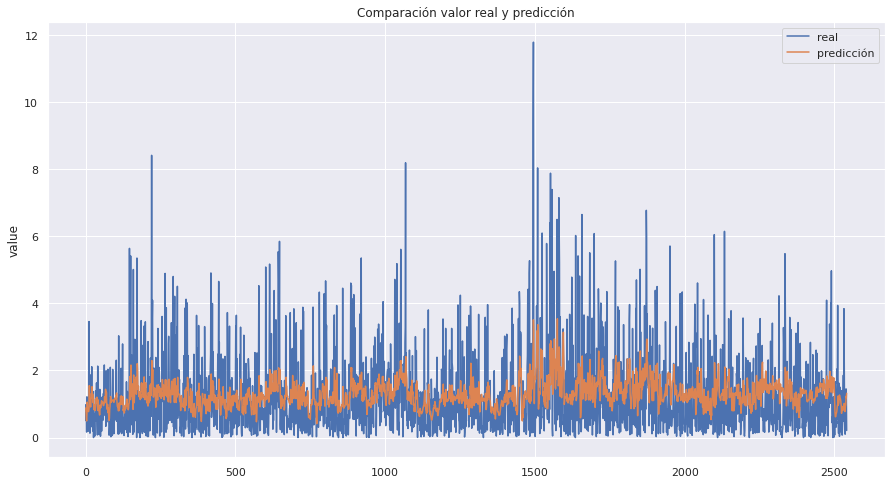

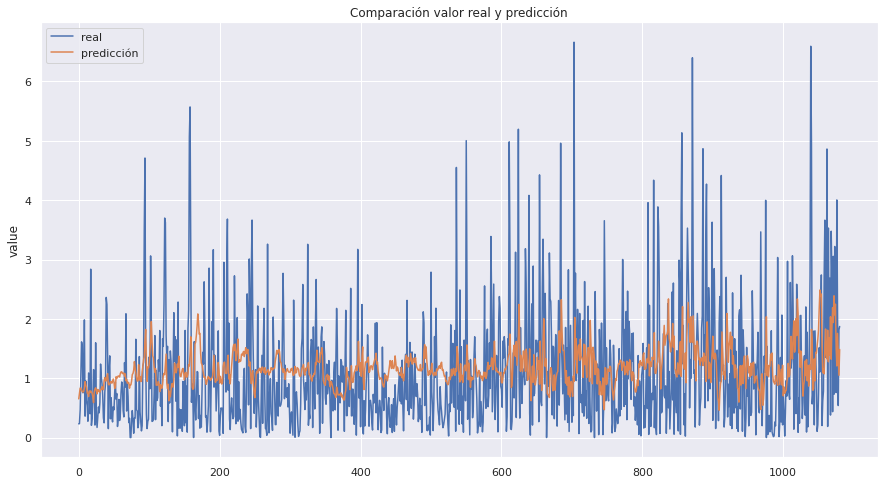

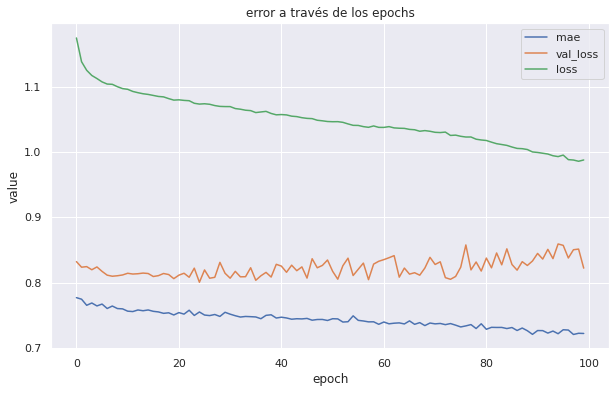

34/34 [==============================] - 0s 4ms/step
Evaluation metric results:
MSE is : 1.229622297887383
MAE is : 0.8124192493692743
RMSE is : 1.108883356303711
MAPE is : 39.93533595983468
Evaluation metric results:
MSE is : 1.013896827546378
MAE is : 0.7620741451328311
RMSE is : 1.0069244398396426
MAPE is : 40.59147533117607
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 6s 17ms/step - loss: 1.1551 - mae: 0.7696 - val_loss: 0.8228 - val_mae: 0.7225
Epoch 2/100
128/128 [==============================] - 1s 11ms/step - loss: 1.1215 - mae: 0.7741 - val_loss: 0.8042 - val_mae: 0.7051
Epoch 3/100
128/128 [==============================] - 1s 12ms/step - loss: 1.1117 - mae: 0.7597 - val_loss: 0.8164 - val_mae: 0.7178
Epoch 4/100
128/128 [==============================] - 1s 12ms/step - loss: 1.1073 - mae: 0.7685 - val_loss: 0.8093 - val_mae: 0.7118
Epoch 5/100
128/128 [==============================] - 1s 12ms/step - loss: 1.1022 - m

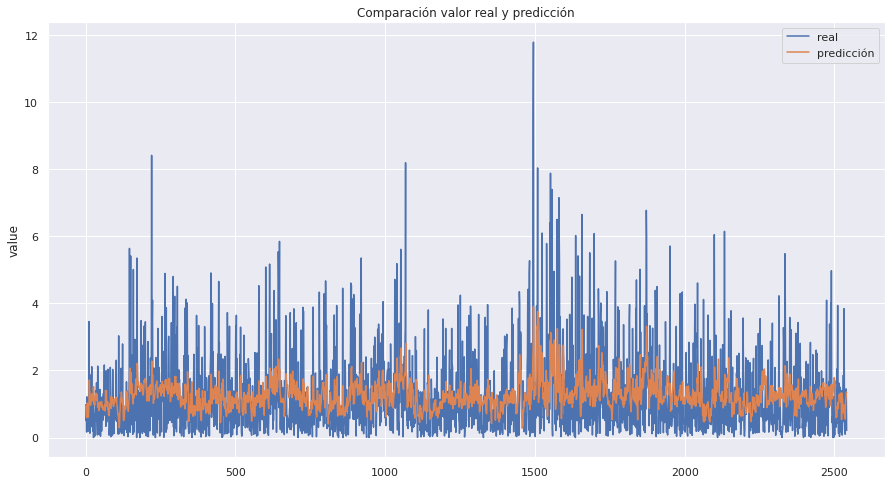

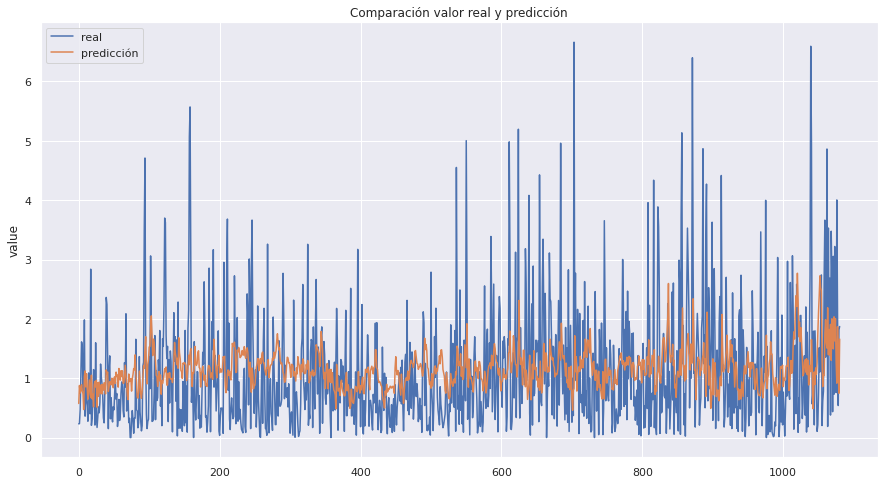

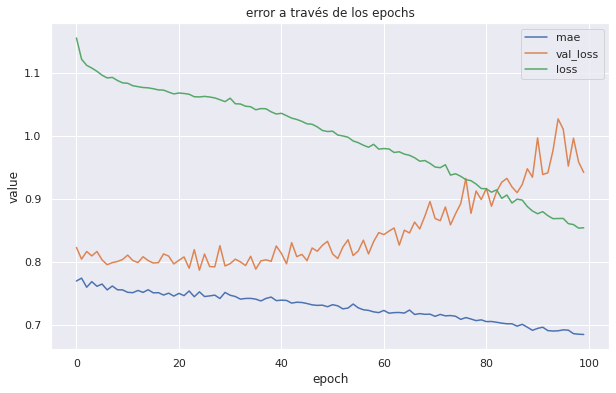

34/34 [==============================] - 0s 5ms/step
Evaluation metric results:
MSE is : 1.1114387225566613
MAE is : 0.7816388860088453
RMSE is : 1.054247941689554
MAPE is : 38.57808537171357
Evaluation metric results:
MSE is : 1.1503271183854178
MAE is : 0.8100464150884513
RMSE is : 1.0725330383654472
MAPE is : 43.70558643803262
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 5s 20ms/step - loss: 1.1453 - mae: 0.7682 - val_loss: 0.8271 - val_mae: 0.7210
Epoch 2/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1187 - mae: 0.7718 - val_loss: 0.7989 - val_mae: 0.7013
Epoch 3/100
128/128 [==============================] - 2s 16ms/step - loss: 1.1079 - mae: 0.7560 - val_loss: 0.8186 - val_mae: 0.7165
Epoch 4/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1049 - mae: 0.7670 - val_loss: 0.8083 - val_mae: 0.7112
Epoch 5/100
128/128 [==============================] - 2s 17ms/step - loss: 1.1001 -

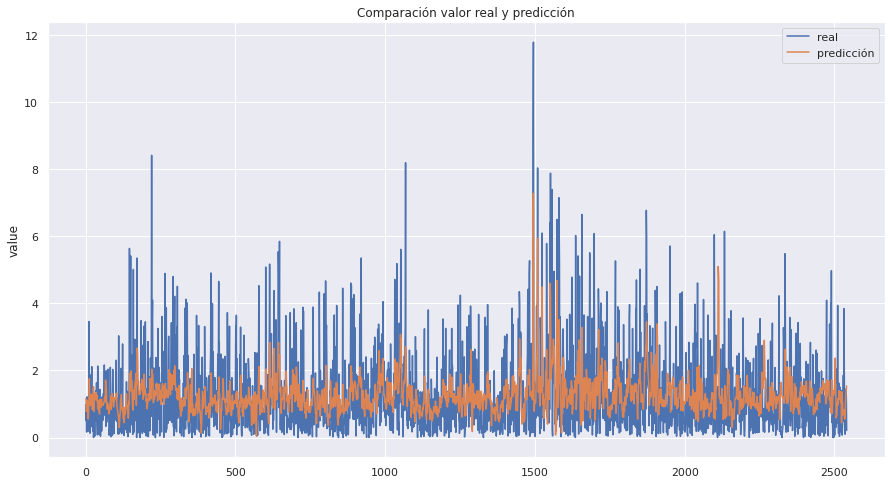

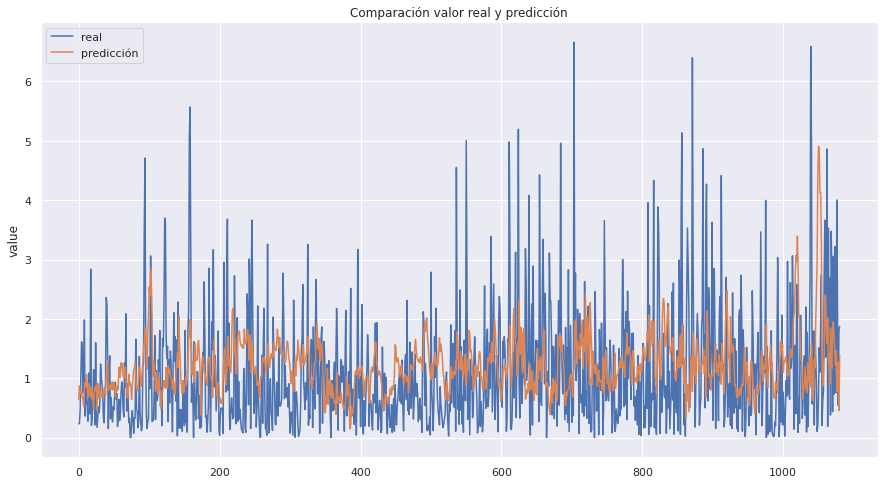

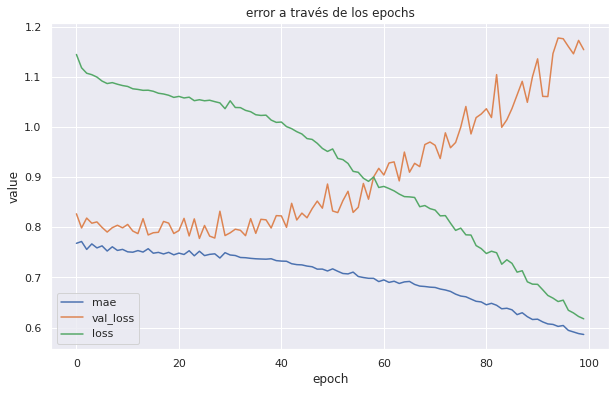

34/34 [==============================] - 0s 8ms/step
Evaluation metric results:
MSE is : 0.9110451327413557
MAE is : 0.7015936890821649
RMSE is : 0.9544868426234883
MAPE is : 35.15570747164877
Evaluation metric results:
MSE is : 1.4861377579083699
MAE is : 0.8776941650287763
RMSE is : 1.2190724990370219
MAPE is : 46.11721880038041
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 8s 33ms/step - loss: 1.1468 - mae: 0.7672 - val_loss: 0.8339 - val_mae: 0.7257
Epoch 2/100
128/128 [==============================] - 3s 25ms/step - loss: 1.1141 - mae: 0.7685 - val_loss: 0.7882 - val_mae: 0.6929
Epoch 3/100
128/128 [==============================] - 3s 26ms/step - loss: 1.1008 - mae: 0.7530 - val_loss: 0.8211 - val_mae: 0.7115
Epoch 4/100
128/128 [==============================] - 3s 26ms/step - loss: 1.0993 - mae: 0.7637 - val_loss: 0.7992 - val_mae: 0.7041
Epoch 5/100
128/128 [==============================] - 3s 26ms/step - loss: 1.0971 

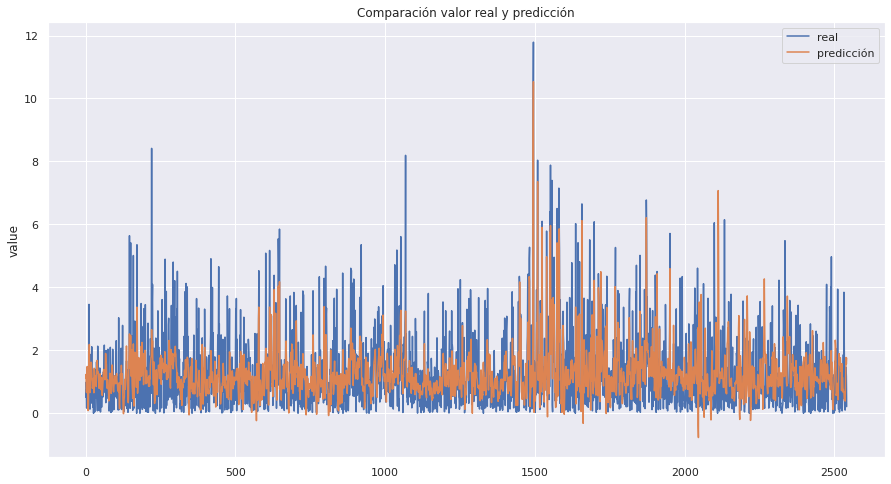

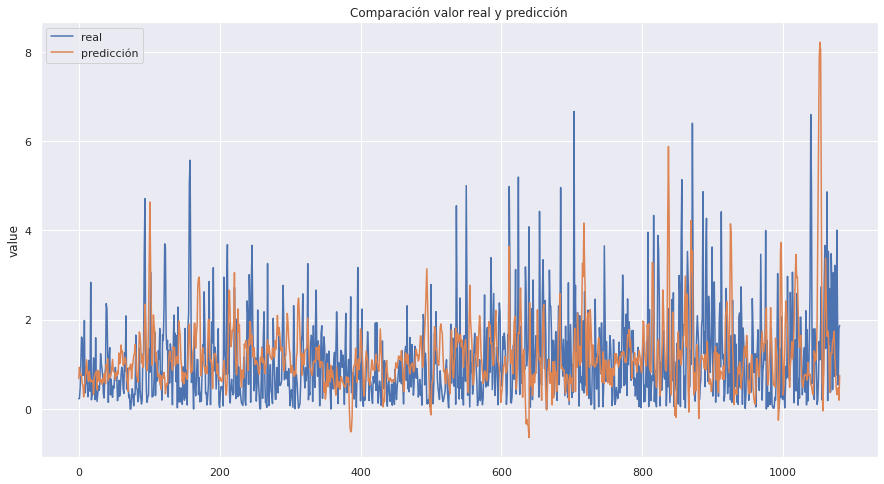

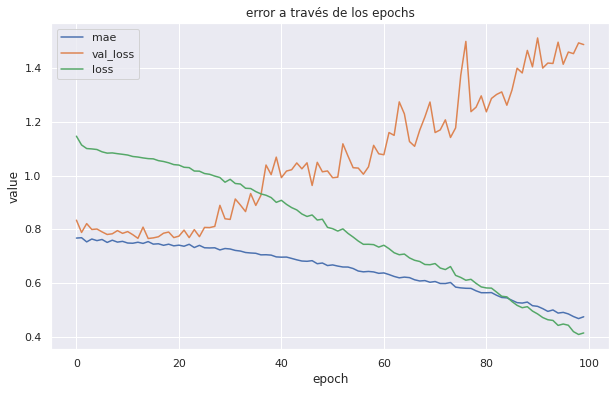

34/34 [==============================] - 0s 13ms/step
Evaluation metric results:
MSE is : 0.7755027995920901
MAE is : 0.6110213201081098
RMSE is : 0.8806263677588186
MAPE is : 31.017901784272915
Evaluation metric results:
MSE is : 1.6924323477487846
MAE is : 0.9339543397595996
RMSE is : 1.3009351819936243
MAPE is : 49.01786864161146
(2542, 15, 4) (2542, 1)
(1081, 15, 4) (1081, 1)
Epoch 1/100
128/128 [==============================] - 10s 57ms/step - loss: 1.1385 - mae: 0.7643 - val_loss: 0.8075 - val_mae: 0.7106
Epoch 2/100
128/128 [==============================] - 7s 53ms/step - loss: 1.1119 - mae: 0.7663 - val_loss: 0.7715 - val_mae: 0.6836
Epoch 3/100
128/128 [==============================] - 7s 52ms/step - loss: 1.0952 - mae: 0.7518 - val_loss: 0.7981 - val_mae: 0.6973
Epoch 4/100
128/128 [==============================] - 7s 52ms/step - loss: 1.0942 - mae: 0.7611 - val_loss: 0.7774 - val_mae: 0.6923
Epoch 5/100
128/128 [==============================] - 7s 51ms/step - loss: 1.09

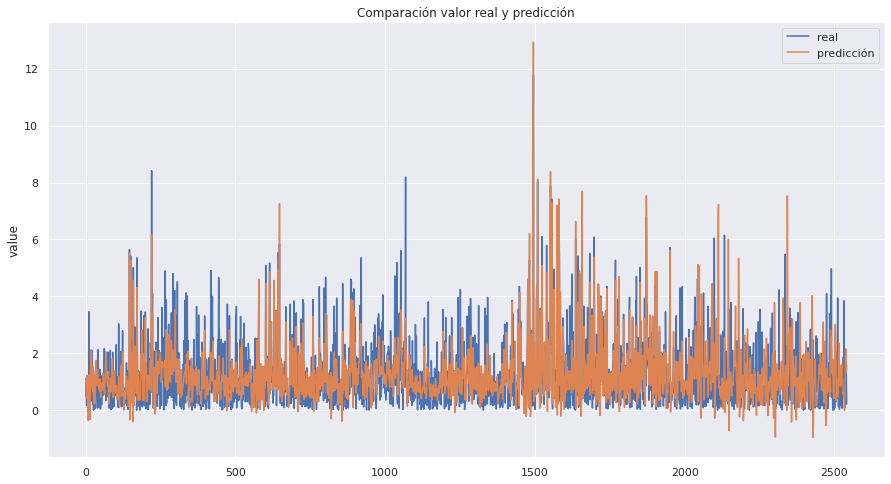

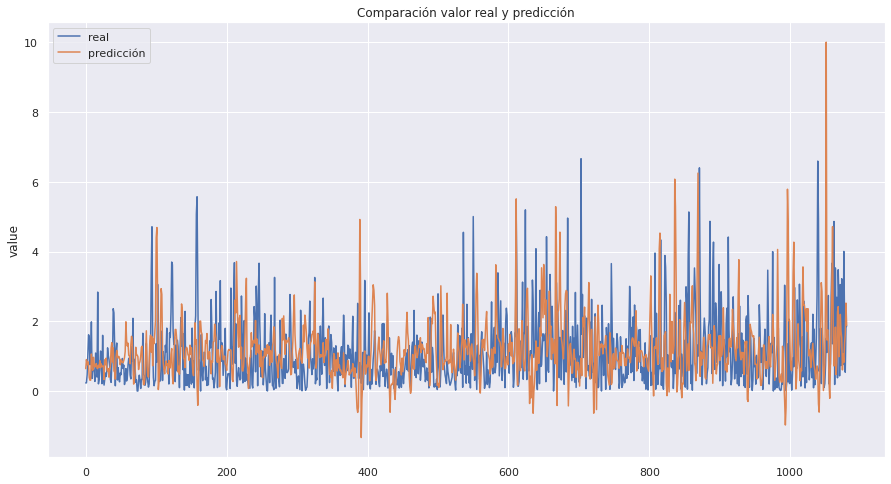

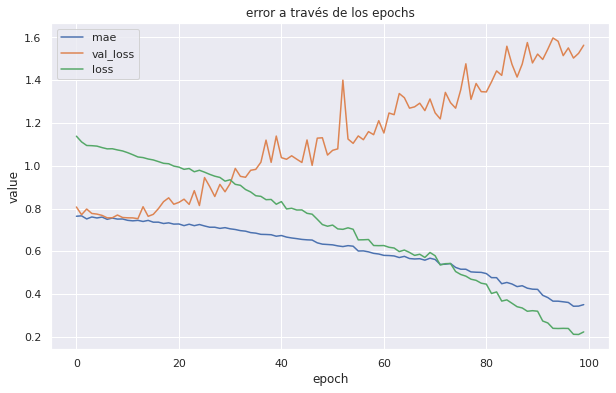

34/34 [==============================] - 1s 22ms/step
Evaluation metric results:
MSE is : 0.5864236518977263
MAE is : 0.5019118223289714
RMSE is : 0.7657830318685093
MAPE is : 25.967984516886222
Evaluation metric results:
MSE is : 1.7053760896899803
MAE is : 0.948568013697258
RMSE is : 1.3059004899646758
MAPE is : 49.28097312370882


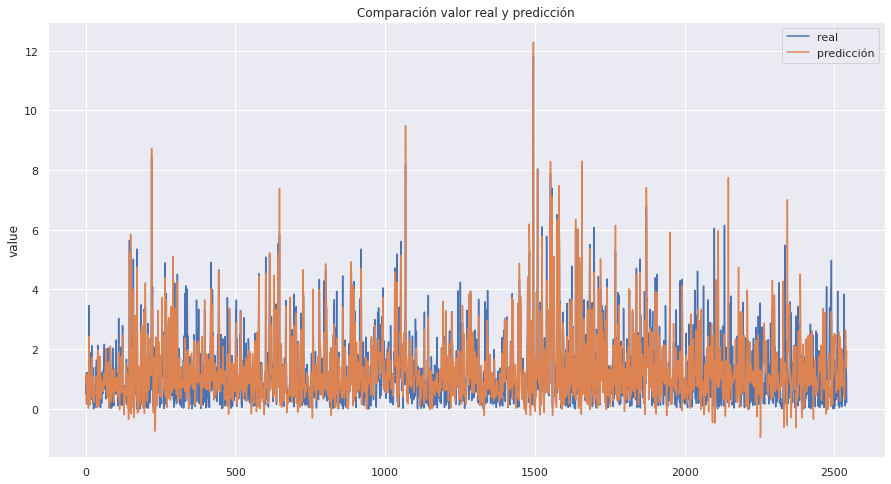

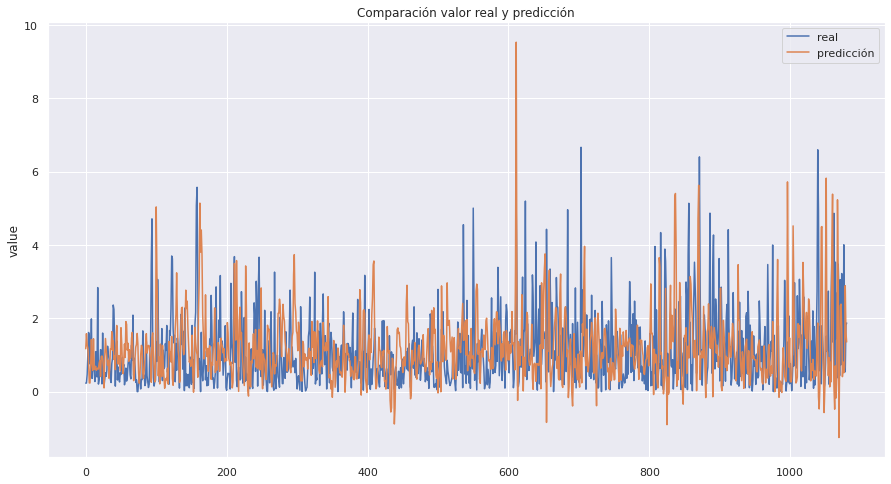

In [26]:
neuronss=[16,32,64,128,256,512]
results_model_lag15_epohs100=[]
for neuron in neuronss:
    results_model_lag15_epohs100.append(Model(df_train,df_train_y_normalize,df_test,df_test_y_normalize,neurons=neuron,attributes=4,epochss=100,batch_sizze=16,lag=15))